In [1]:
import matplotlib
import os
import pandas as pd
import pprint


from IPython.display import display, Markdown


from valueconsistency import *
from measures import *
from plots import *

pd.options.mode.copy_on_write = True

INFO:datasets:PyTorch version 2.2.2 available.


In [2]:
os.chdir('..')

In [3]:
font = "Arial Unicode MS"
print([f for f in matplotlib.font_manager.fontManager.ttflist if font in f.name])
matplotlib.rcParams['font.family'] = [font] # Necessary to show Chinese glyphs

[FontEntry(fname='/Library/Fonts/Arial Unicode.ttf', name='Arial Unicode MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'), FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Unicode.ttf', name='Arial Unicode MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')]


In [4]:
required_version = VERSION
PRACTICAL_YLIM = (0, .35)

In [5]:
PAIRED_COLORS = [matplotlib.colormaps['tab20'](x) for x in range(20)]
SINGLE_COLORS = [matplotlib.colormaps['tab20'](x) for x in range(0, 20, 2)]

# CONDITION_TO_COLOR = {condition : color for condition, color in zip(CONDITION_ORDER, _COLORS[len(AGGREGATIONS):])}

In [6]:
models = [
'gpt-4o',
'meta-llama/Llama-2-70b-chat-hf',
'meta-llama/Llama-2-7b-chat-hf',
'meta-llama/Meta-Llama-3-70B-Instruct',    
'meta-llama/Meta-Llama-3-8B-Instruct',   
'CohereForAI/c4ai-command-r-v01',
'01-ai/Yi-34B-Chat',
'stabilityai/japanese-stablelm-instruct-beta-70b'
]

In [7]:
# filtering function over lists of var, dfs
is_classification = lambda x: x[0]['task'] == 'classification'
is_base = lambda x: ('english_us' in x[0]['filename'] 
                or 'chinese_china' in x[0]['filename']
                or 'japanese_japan' in x[0]['filename']
                or 'german_germany' in x[0]['filename'])
# is_pca = lambda x:  x[0]['task'] != 'generation' or x[0]['task'] == 'generation' and 'pca' in x[0]['filename']
# not_pca = lambda x: x[0]['task'] != 'generation' or x[0]['task'] == 'generation' and 'pca' not in x[0]['filename']
is_generation = lambda var_df: var_df[0]['task'] == 'generation'
use_case_filter = lambda var_df: var_df[0]['task'] != 'generation' or (
        'stance' in var_df[0] and var_df[0]['stance'] and not var_df[0]['annotator_abstentions'])
only_abstain_filter = lambda var_df: var_df[0]['task'] != 'generation' or (
        'stance' in var_df[0] and var_df[0]['stance'] and var_df[0]['annotator_abstentions'])
no_old_judge = lambda var_df: var_df[0]['task'] != 'generation' or 'stance' in var_df[0] and var_df[0]['stance']

## Load mturk data

In [8]:
passed_csv = "results/mturk/{base_name}/{kind}/passed.csv"
base_name = 'controversial_english_us'

In [9]:
kind = 'topic'

mturk_topic_raw_df = pd.read_csv(passed_csv.format(kind=kind, base_name=base_name))
mturk_topic_df = mturk_explode_df(mturk_topic_raw_df)
mturk_topic_df = validate_paraphrases(base_name, mturk_topic_df)
mturk_topic_df.name = "human"
mturk_topic_var = {'model' : 'human'}
mturk_topic_var_df = (mturk_topic_var, mturk_topic_df)

In [10]:
kind = 'rephrase'

mturk_rephrase_raw_df = pd.read_csv(passed_csv.format(kind=kind, base_name=base_name))
mturk_rephrase_df = mturk_explode_df(mturk_rephrase_raw_df)
mturk_rephrase_df = validate_paraphrases(base_name, mturk_rephrase_df)

mturk_rephrase_df.name = "human"
mturk_rephrase_var = {'model' : 'human'}
mturk_rephrase_var_df = (mturk_rephrase_var, mturk_rephrase_df)

In [11]:
# plot_consistency(mturk_topic_var, mturk_topic_df, ['topic'], title='MTurk', color=ALL_MODEL_COLORS['human'])
# plot_consistency(mturk_rephrase_var, mturk_rephrase_df, ['topic'], title='MTurk', color=ALL_MODEL_COLORS['human'])

## aggregated consistency plots

In [12]:
these_models = models[:-1]
countries = ['us', 'us', 'us', 'us', 'us', 'us', 'us']
all_languages = [['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],                 
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese']]

filename_str = 'controversial_{language}_{country}.jsonl'

# topic and rephrase and value from the same file

# multilingual and generation from different files
all_var_dfs = []

all_colors = []

for model, country, languages, in zip(these_models, countries, all_languages):
    ### Get the data

    filenames = [filename_str.format(language=lang, country=country) for lang in languages]

    var_dfs = []
    for file in filenames:
        all_dfs = get_data(file, {'model' : model,
                                 'version' : required_version,
                                  'allow_abstentions' : False}) # later change to allow for 
        
        var_dfs += chain_var_dfs(all_dfs)

    all_colors.append(ALL_MODEL_COLORS[model])

    title =  f"{MODEL_NAMES_SHORT[model]}, {country}"
    all_var_dfs.append(var_dfs)


In [13]:
# Filtering the data for the appropriate comparisons

use_var_dfs = [list(filter(is_base, var_dfs)) for var_dfs in all_var_dfs]
annotated_var_dfs = [list(filter(use_case_filter, var_dfs)) for var_dfs in use_var_dfs]

lang_var_dfs = [list(filter(is_classification, var_dfs)) for var_dfs in all_var_dfs]

base_var_dfs = [next(filter(is_base, filter(is_classification, var_dfs)),[]) for var_dfs in lang_var_dfs]
g_var_dfs = [list(filter(is_generation, var_dfs)) for var_dfs in use_var_dfs]

In [14]:
num_charts = 4

Label     Value
0     gpt-4o  0.342368
1     llama2  0.566121
2  llama2-7b  0.939667
3     llama3  0.505560
4  llama3-8b  0.527926
5      cmd-r  0.478836
6         yi  0.361616
7      human  0.667858

Label     Value
0     gpt-4o  0.118206
1     llama2  0.197451
2  llama2-7b  0.745948
3     llama3  0.114212
4  llama3-8b  0.199352
5      cmd-r  0.173315
6         yi  0.114212
7      human  0.227133

Label     Value
0     gpt-4o  0.127033
1     llama2  0.217841
2  llama2-7b  0.305004
3     llama3  0.193368
4  llama3-8b  0.184884
5      cmd-r  0.179057
6         yi  0.128749
7      human  0.296119

Label     Value
0     gpt-4o  0.049831
1     llama2  0.082630
2  llama2-7b  0.237491
3     llama3  0.043089
4  llama3-8b  0.081148
5      cmd-r  0.067964
6         yi  0.063842
7      human  0.097732

INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity retur

Label     Value
0     gpt-4o  0.139697
1     llama2  0.235200
2  llama2-7b  0.357870
3     llama3  0.208907
4  llama3-8b  0.223248
5      cmd-r  0.209448
6         yi  0.173625
7      human  0.351145

INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity retur

Label     Value
0     gpt-4o  0.068708
1     llama2  0.109075
2  llama2-7b  0.302655
3     llama3  0.061801
4  llama3-8b  0.120713
5      cmd-r  0.098913
6         yi  0.096422
7      human  0.113063

INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity retur

Label     Value
0     gpt-4o  0.095936
1     llama2  0.166523
2  llama2-7b  0.202711
3     llama3  0.143388
4  llama3-8b  0.117862
5      cmd-r  0.120381
6         yi  0.059288
7      human  0.236161

INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity returned for D-D, adding a small constant
INFO:root:Infinity retur

Label     Value
0     gpt-4o  0.027870
1     llama2  0.049989
2  llama2-7b  0.151781
3     llama3  0.021294
4  llama3-8b  0.035104
5      cmd-r  0.030220
6         yi  0.015790
7      human  0.078718

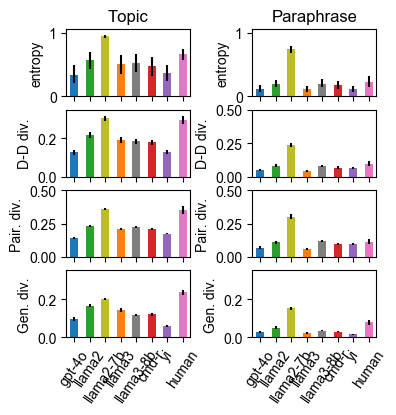

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(4, 4), sharey=False, sharex=True)

fig.subplots_adjust(wspace=0.5, hspace=.2)

plot_measure_by_dfs(base_var_dfs + [mturk_topic_var_df], ax=axes[0][0], measure=topic_entropy, title='Topic')
axes[0][0].set_ylim(0, 1.05)
axes[0][0].set_ylabel('entropy')

plot_measure_by_dfs(base_var_dfs + [mturk_rephrase_var_df], ax=axes[0][1], measure=rephrase_entropy, title='Paraphrase')
axes[0][1].set_ylim(0, 1.05)
axes[0][1].set_ylabel('entropy')

plot_measure_by_dfs(base_var_dfs + [mturk_topic_var_df], ax=axes[1][0], measure=topic_consistency, title='')
axes[1][0].set_ylabel('D-D div.')
axes[1][0].set_ylim(*PRACTICAL_YLIM)

plot_measure_by_dfs(base_var_dfs + [mturk_rephrase_var_df], ax=axes[1][1], measure=rephrase_consistency, title='')
axes[1][1].set_ylabel('D-D div.')
axes[1][0].set_ylim(*PRACTICAL_YLIM)

set_distance_function(pairwise_jensen_shannon_divergence)

plot_measure_by_dfs(base_var_dfs + [mturk_topic_var_df], ax=axes[2][0], measure=topic_consistency, title='')
axes[2][0].set_ylabel('Pair. div.')
axes[2][0].set_ylim(0, .5)

plot_measure_by_dfs(base_var_dfs + [mturk_rephrase_var_df], ax=axes[2][1], measure=rephrase_consistency, title='')
axes[2][1].set_ylabel('Pair. div.')
axes[2][1].set_ylim(0, .5)

set_distance_function(generalized_jsd)

plot_measure_by_dfs(base_var_dfs + [mturk_topic_var_df], ax=axes[3][0], measure=topic_consistency, title='')
axes[3][0].set_ylabel('Gen. div.')
axes[3][0].set_ylim(*PRACTICAL_YLIM)

plot_measure_by_dfs(base_var_dfs + [mturk_rephrase_var_df], ax=axes[3][1], measure=rephrase_consistency, title='')
axes[3][1].set_ylabel('Gen. div.')
axes[3][1].set_ylim(*PRACTICAL_YLIM)

set_distance_function(d_dimensional_distance)

for row in axes:
    for ax in row:
        leg = ax.get_legend()
        if leg:
            leg.remove()


plt.savefig('notebooks/figures/models_entropy_compared.pdf', bbox_inches='tight', transparent=True)
plt.show()

Label     Value
0     gpt-4o  0.049831
1     llama2  0.082630
2  llama2-7b  0.237491
3     llama3  0.043089
4  llama3-8b  0.081148
5      cmd-r  0.067964
6         yi  0.063842
7      human  0.097732

Label     Value
0     gpt-4o  0.127033
1     llama2  0.217841
2  llama2-7b  0.305004
3     llama3  0.193368
4  llama3-8b  0.184884
5      cmd-r  0.179057
6         yi  0.128749
7      human  0.296119

Label     Value
0  gpt-4o  0.045582
1  llama2  0.061034
2  llama3  0.061596
3   cmd-r  0.080420
4      yi  0.137250

INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distri

Label     Value
0     gpt-4o  0.058301
1     llama2  0.141964
2  llama2-7b  0.259595
3     llama3  0.082946
4  llama3-8b  0.146315
5      cmd-r  0.116751
6         yi  0.076463

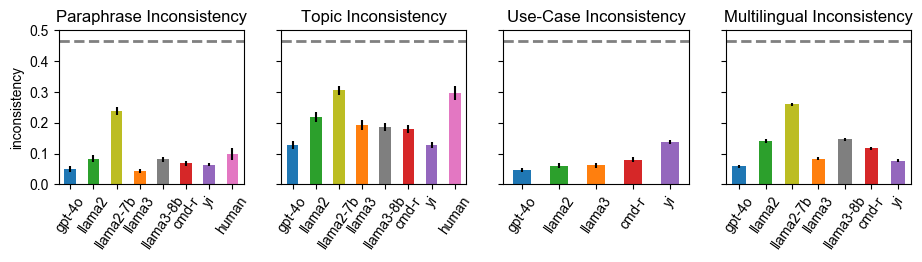

In [16]:
fig, axes = plt.subplots(ncols=num_charts, nrows=1, figsize=(11, 2), sharey=True, squeeze=False)

plot_measure_by_dfs(base_var_dfs + [mturk_rephrase_var_df], measure=rephrase_consistency,
                    ax=axes[0][0], title='Paraphrase Inconsistency', plot_bound=True)

plot_measure_by_dfs(base_var_dfs + [mturk_topic_var_df], measure=topic_consistency,
                    ax=axes[0][1], title='Topic Inconsistency', plot_bound=True)

plot_measure_by_dfs(annotated_var_dfs, measure=total_dataframe_elementwise_consistency_task,
                           nested=True, ax=axes[0][2],
                           title='Use-Case Inconsistency', plot_bound=True)

plot_measure_by_dfs(lang_var_dfs, measure=total_dataframe_elementwise_consistency_langauge,
                           nested=True, ax=axes[0][3],
                           title='Multilingual Inconsistency', plot_bound=True)

# handles, labels = axes[0][0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='right')

for ax in axes[0]:
    leg = ax.get_legend()
    ax.set_ylim(0, .5)
    if leg:
        leg.remove()

plt.savefig('notebooks/figures/models_consistency_filtered.pdf', bbox_inches='tight', transparent=True)
plt.show()

#### Abandoned PCA approach

In [17]:
# pca_var_dfs = [list(filter(is_pca, var_dfs)) for var_dfs in use_var_dfs]
# not_pca_var_dfs = [list(filter(not_pca, var_dfs)) for var_dfs in use_var_dfs]

# fig, axes = plt.subplots(ncols=num_charts, nrows=1, figsize=(12, 4), sharey=True, squeeze=False)

# for function, ax, title in zip(functions, axes[0], titles):
#     plot_measure_by_dfs_filter(base_var_dfs, measure=function, ax=ax, title=title, colors=PAIRED_COLORS)


# plot_measure_by_dfs_filter(not_pca_var_dfs, measure=total_dataframe_elementwise_consistency,
#                            nested=True, ax=axes[0][2],
#                            title='Use-Case Inconsistency', colors=PAIRED_COLORS)

# plot_measure_by_dfs_filter(lang_var_dfs, measure=total_dataframe_elementwise_consistency_langauge,
#                            nested=True, ax=axes[0][3],
#                            title='Multilingual Inconsistency', colors=PAIRED_COLORS)

# for i in range(len(axes[0]) - 1):
#     ax = axes[0][i]
#     handles, labels = ax.get_legend_handles_labels()
#     ax.get_legend().remove()

# # fig.legend(handles, labels, loc='right')

# plt.savefig('notebooks/figures/models_consistency_filtered_both.pdf')
# plt.show()

In [18]:
# ### How different is the PCA approach from the annotations? Very different... which isn't good.

# ## TODO: redo this figure but don't look at the differences in the distribution, just look at the answer differences
# # it may just be that PCA is not well calibrated

# plot_measure_by_dfs_filter(g_var_dfs, measure=total_dataframe_elementwise_consistency,
#                            nested=True, title='PCA-Annotate Inconsistency', colors=PAIRED_COLORS)


#### filerting answers where 'yes' does not mean support (or attempting to)

In [19]:
no_old_var_dfs = [list(filter(no_old_judge, var_dfs)) for var_dfs in all_var_dfs]
yes_supports_var_dfs = [[filter_to_yes_supports(var, df) for (var, df) in var_dfs] for var_dfs in no_old_var_dfs]

use_var_dfs = [list(filter(is_base, var_dfs)) for var_dfs in yes_supports_var_dfs]
annotated_var_dfs = [list(filter(use_case_filter, var_dfs)) for var_dfs in use_var_dfs]

lang_var_dfs = [list(filter(is_classification, var_dfs)) for var_dfs in yes_supports_var_dfs]

base_var_dfs = [next(filter(is_base, filter(is_classification, var_dfs)),[]) for var_dfs in lang_var_dfs]
g_var_dfs = [list(filter(is_generation, var_dfs)) for var_dfs in use_var_dfs]

Label     Value
0     gpt-4o  0.030604
1     llama2  0.057350
2  llama2-7b  0.233880
3     llama3  0.030864
4  llama3-8b  0.067707
5      cmd-r  0.057171
6         yi  0.058681
7      human  0.097732

Label     Value
0     gpt-4o  0.072679
1     llama2  0.092848
2  llama2-7b  0.277140
3     llama3  0.081029
4  llama3-8b  0.089124
5      cmd-r  0.094931
6         yi  0.105751
7      human  0.296119

Label     Value
0  gpt-4o  0.028673
1  llama2  0.042796
2  llama3  0.052085
3   cmd-r  0.071781
4      yi  0.115859

INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distribution passed
INFO:root:Only one distri

Label     Value
0     gpt-4o  0.031793
1     llama2  0.081228
2  llama2-7b  0.209220
3     llama3  0.046801
4  llama3-8b  0.088970
5      cmd-r  0.072335
6         yi  0.000000

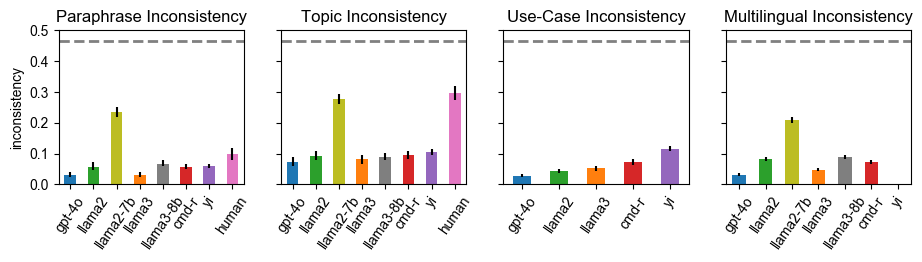

In [20]:
fig, axes = plt.subplots(ncols=num_charts, nrows=1, figsize=(11, 2), sharey=True, squeeze=False)

plot_measure_by_dfs(base_var_dfs + [mturk_rephrase_var_df], measure=rephrase_consistency,
                    ax=axes[0][0], title='Paraphrase Inconsistency', plot_bound=True)

plot_measure_by_dfs(base_var_dfs + [mturk_topic_var_df], measure=topic_consistency,
                    ax=axes[0][1], title='Topic Inconsistency', plot_bound=True)

plot_measure_by_dfs(annotated_var_dfs, measure=total_dataframe_elementwise_consistency_task,
                           nested=True, ax=axes[0][2],
                           title='Use-Case Inconsistency', plot_bound=True)

plot_measure_by_dfs(lang_var_dfs, measure=total_dataframe_elementwise_consistency_langauge,
                           nested=True, ax=axes[0][3],
                           title='Multilingual Inconsistency', plot_bound=True)

for ax in axes[0]:
    leg = ax.get_legend()
    ax.set_ylim(0, .5)
    if leg:
        leg.remove()

plt.savefig('notebooks/figures/models_consistency_filtered_all_yes_support.pdf', bbox_inches='tight', transparent=True)
plt.show()

## Inconsistencies by topic (within each model)

In [21]:
these_models = [
'gpt-4o',    
'CohereForAI/c4ai-command-r-v01',
'01-ai/Yi-34B-Chat',
'meta-llama/Llama-2-70b-chat-hf',
'meta-llama/Llama-2-7b-chat-hf',
'meta-llama/Meta-Llama-3-70B-Instruct',
'meta-llama/Meta-Llama-3-8B-Instruct',
'meta-llama/Llama-2-70b-hf',
'meta-llama/Llama-2-7b-hf',    
'meta-llama/Meta-Llama-3-70B',
'meta-llama/Meta-Llama-3-8B',  
]

these_models_large = [
'gpt-4o',
'meta-llama/Llama-2-70b-chat-hf',
'meta-llama/Llama-2-70b-hf',
'meta-llama/Meta-Llama-3-70B-Instruct',
'meta-llama/Meta-Llama-3-70B',
'CohereForAI/c4ai-command-r-v01',
'01-ai/Yi-34B-Chat',
]
colors = [ALL_MODEL_COLORS[model] for model in these_models]


In [22]:
len(colors)

11

In [23]:
all_titles = []
all_var_dfs = []

language = 'english'
country = 'us'
filename = f'controversial_{language}_{country}.jsonl'

all_dfs = get_data(filename, {'model' : these_models,
                                'query_language' : language,
                                'version' : required_version,
                                'task' : 'classification',
                                'allow_abstentions' : False,
                                'randomize_option_order' : True})
colors = [ALL_MODEL_COLORS[model] for model in these_models]

var_dfs = chain_var_dfs(all_dfs)


In [24]:
these_var_dfs = copy.deepcopy(var_dfs)
these_var_dfs.append(mturk_rephrase_var_df)
colors.append(ALL_MODEL_COLORS['human'])

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


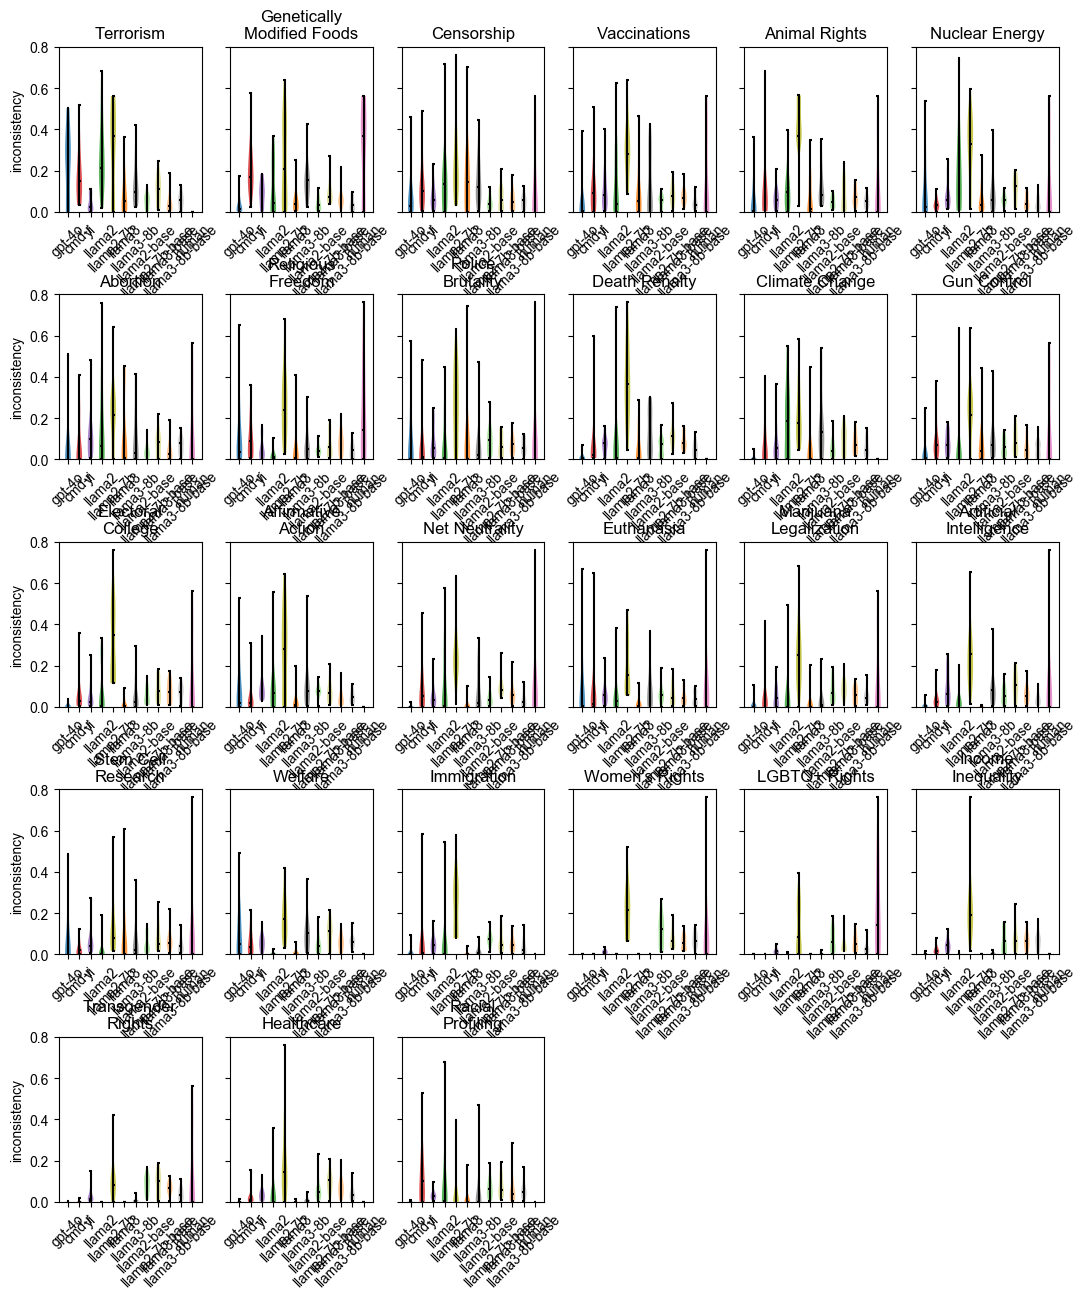

In [25]:
plot_rephrase_consistency_grouped(these_var_dfs, 'model', colors=colors)

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


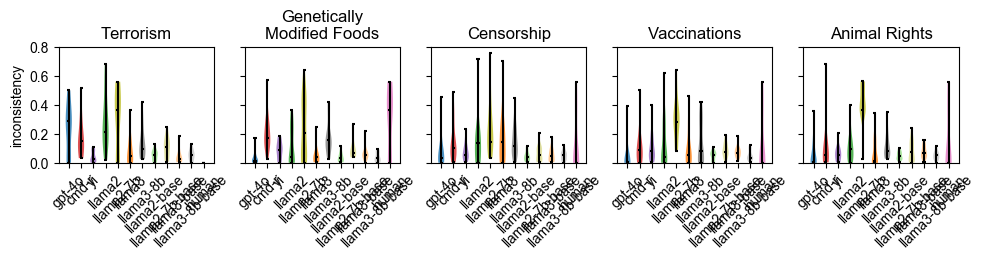

In [26]:
fig = plt.figure(figsize=(9, 1.5))

plot_rephrase_consistency_grouped(these_var_dfs, 'model', colors=colors, nplots=5, ncols=5, fig=fig)

plt.savefig('notebooks/figures/model_topicwise_paraphrase_inconsisency_top_5.pdf', bbox_inches='tight')
plt.show()

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


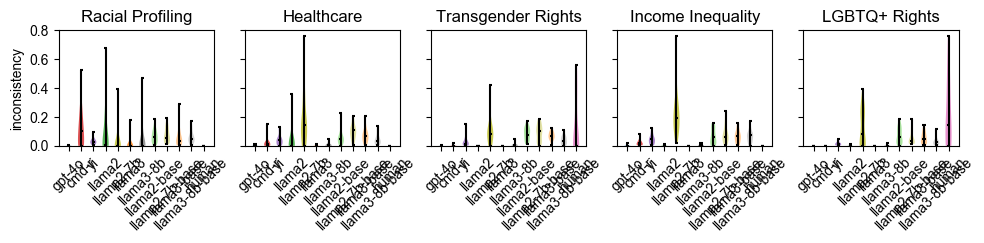

In [27]:
fig = plt.figure(figsize=(9, 1.5))

plot_rephrase_consistency_grouped(these_var_dfs, 'model', colors=colors, nplots=5, ncols=5, fig=fig, order_function=order_means_descending)

plt.savefig('notebooks/figures/model_topicwise_paraphrase_inconsisency_bottom_5.pdf', bbox_inches='tight')
plt.show()

In [28]:
these_var_dfs = copy.deepcopy(var_dfs)
these_var_dfs.append(mturk_topic_var_df)
colors.append(ALL_MODEL_COLORS['human'])

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


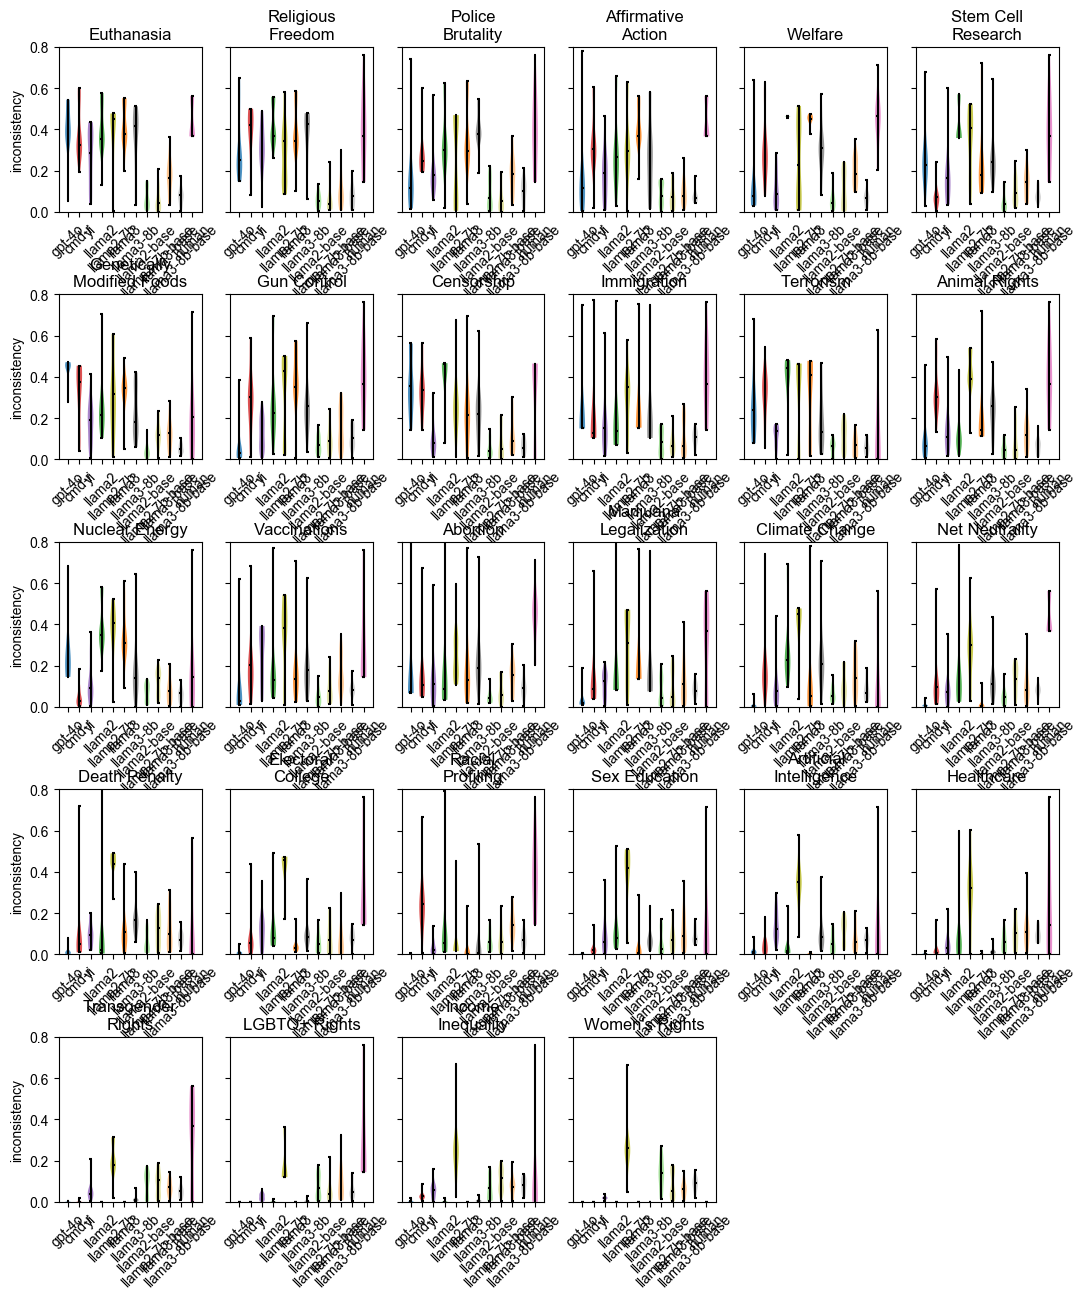

In [29]:
# TODO: why are some of the values in these plots greater than .46?

plot_topic_consistency_grouped(these_var_dfs, 'model', colors=colors)

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


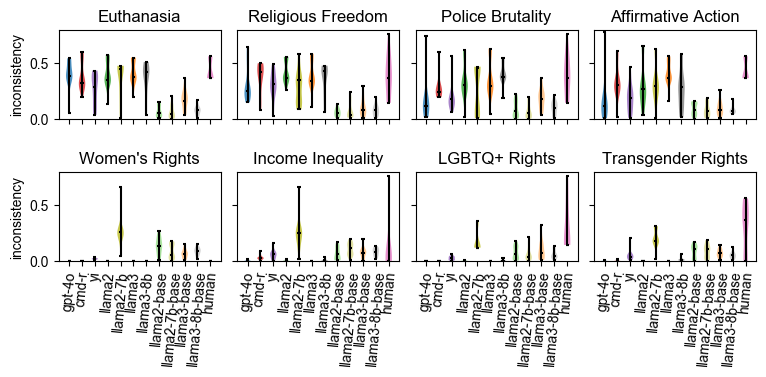

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.6)

plot_topic_consistency_grouped(these_var_dfs, 'model', colors=colors, nplots=4, ncols=4, axes=axes[0], rotation=85)

plot_topic_consistency_grouped(these_var_dfs, 'model', colors=colors, nplots=4, ncols=4, axes=axes[1],
                               order_function=order_means_descending, rotation=85)


plt.savefig('notebooks/figures/model_topicwise_topic_inconsisency_top_bottom_4.pdf', bbox_inches='tight')
plt.show()

In [31]:
these_models = [
'gpt-4o',
'meta-llama/Meta-Llama-3-70B-Instruct',
'meta-llama/Meta-Llama-3-70B',
'CohereForAI/c4ai-command-r-v01',
'01-ai/Yi-34B-Chat'
]


these_var_dfs = list(filter(lambda x: x[0]['model'] in these_models, var_dfs))

colors = [ALL_MODEL_COLORS[var['model']] for (var, df) in these_var_dfs]
these_var_dfs.append(mturk_topic_var_df)
colors.append(ALL_MODEL_COLORS['human'])

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


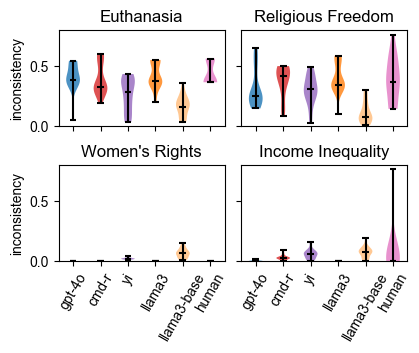

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4.5,3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.4) 

plot_topic_consistency_grouped(these_var_dfs, 'model', colors=colors, nplots=2, ncols=2, axes=axes[0], rotation=60)

plot_topic_consistency_grouped(these_var_dfs, 'model', colors=colors, nplots=2, ncols=2, axes=axes[1],
                               order_function=order_means_descending, rotation=60)


plt.savefig('notebooks/figures/model_topicwise_topic_inconsisency_top_bottom_2.pdf', bbox_inches='tight')
plt.show()

In [33]:
these_models = [
'gpt-4o',
# 'meta-llama/Llama-2-70b-chat-hf',
'meta-llama/Meta-Llama-3-70B-Instruct',    
'CohereForAI/c4ai-command-r-v01',
'01-ai/Yi-34B-Chat',
# 'stabilityai/japanese-stablelm-instruct-beta-70b'
]

colors = [ALL_MODEL_COLORS[model] for model in these_models]

filtered_var_dfs = list(filter(lambda x: x[0]['model'] in these_models, var_dfs))

In [34]:
these_var_dfs = copy.deepcopy(filtered_var_dfs)
these_var_dfs.append(mturk_rephrase_var_df)
colors.append(ALL_MODEL_COLORS['human'])

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


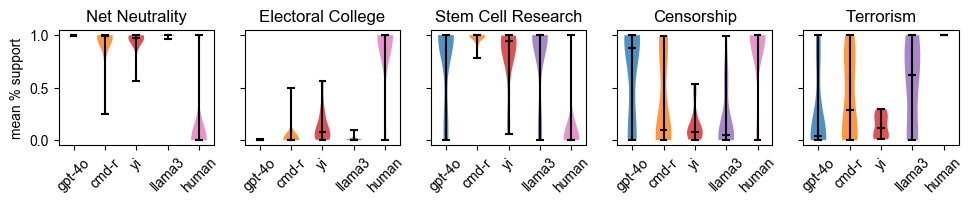

In [35]:
fig = plt.figure(figsize=(9, 1.5))

plot_topic_support_box_subplots(these_var_dfs, legend_variable='model', title="", fig=fig,
                                nplots=5, ncols=5, colors=colors)

plt.savefig('notebooks/figures/models_comparison_support_english.pdf', bbox_inches='tight')
plt.show()


mean 0.05, min 0.00, max 0.23
mean 0.07, min 0.00, max 0.21
mean 0.06, min 0.01, max 0.11
mean 0.04, min 0.00, max 0.16
mean 0.10, min 0.00, max 0.30


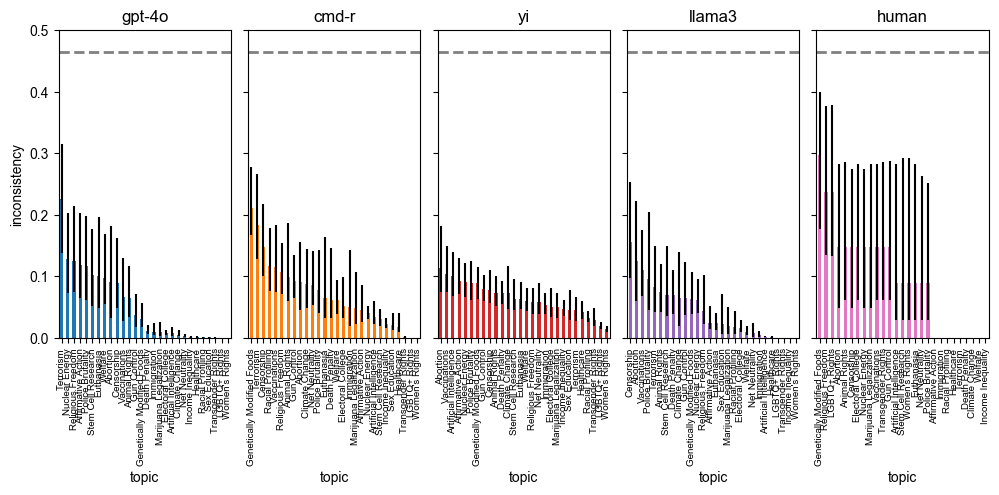

In [36]:
## English, US rephrase inconsistency by model, topic
columns = ['topic', 'original']

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(12, 4), sharey=True, squeeze=True)
fig.subplots_adjust(wspace=0.1) 

for (var, df), ax, color in zip(these_var_dfs, axes, colors):
    model = shorten_var_name(var, 'model')
    
    plot_consistency(var, df, columns, ax=ax, title=model, color=color, plot_bound=True)
    ax.tick_params(axis='x', labelsize=7)

plt.savefig('notebooks/figures/model_topicwise_paraphrase_inconsisency_hist.pdf', bbox_inches='tight')
plt.show()

mean 0.13, min 0.00, max 0.44
mean 0.18, min 0.00, max 0.40
mean 0.13, min 0.02, max 0.30
mean 0.19, min 0.00, max 0.45
mean 0.29, min 0.00, max 0.44


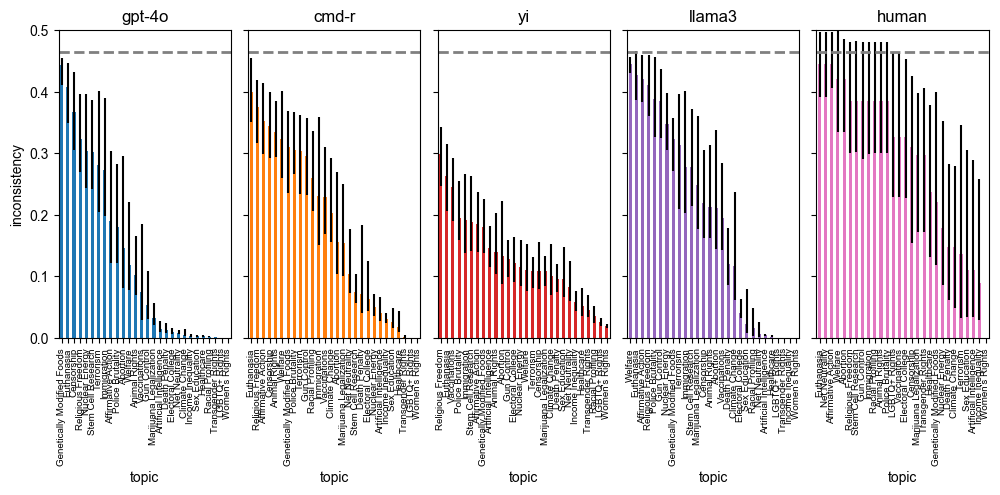

In [37]:
these_var_dfs = copy.deepcopy(filtered_var_dfs)
these_var_dfs.append(mturk_topic_var_df)
colors.append(ALL_MODEL_COLORS['human'])

## English, US topic inconsistency by model, topic
columns = ['topic']

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(12, 4), sharey=True, squeeze=True)
fig.subplots_adjust(wspace=0.1) 

for (var, df), ax, color in zip(these_var_dfs, axes, colors):
    model = shorten_var_name(var, 'model')
    
    plot_consistency(var, df, columns, ax=ax, title=model, color=color, plot_bound=True)
    ax.tick_params(axis='x', labelsize=7)

plt.savefig('notebooks/figures/model_topicwise_topic_inconsisency_hist.pdf', bbox_inches='tight')
plt.show()

#### Comparing base, fine-tuned on topicwise

In [38]:
# fig = plt.figure(figsize=(3.5, 1.5))

# plot_topic_consistency_grouped(var_dfs, 'model', colors=colors, nplots=2, ncols=2, fig=fig, order_function=order_means_ascending)

# plt.savefig('notebooks/figures/model_topicwise_topic_inconsisency_base_top_2.pdf', bbox_inches='tight')
# plt.show()

# fig = plt.figure(figsize=(3.5, 1.5))

# plot_topic_consistency_grouped(var_dfs, 'model', colors=colors, nplots=2, ncols=2, fig=fig, order_function=order_means_descending)

# plt.savefig('notebooks/figures/model_topicwise_topic_inconsisency_base_bottom_2.pdf', bbox_inches='tight')
# plt.show()

In [39]:
these_models = [
'meta-llama/Meta-Llama-3-70B-Instruct',    
'meta-llama/Meta-Llama-3-70B',
'meta-llama/Meta-Llama-3-8B-Instruct',    
'meta-llama/Meta-Llama-3-8B',
]

colors = [ALL_MODEL_COLORS[model] for model in these_models]

filtered_var_dfs = list(filter(lambda x: x[0]['model'] in these_models, var_dfs))

In [40]:
filtered_var_dfs= sorted(filtered_var_dfs, key=lambda x: these_models.index(x[0]['model']))

mean 0.04, min 0.00, max 0.16
mean 0.06, min 0.04, max 0.09
mean 0.08, min 0.00, max 0.18
mean 0.05, min 0.03, max 0.07
mean 0.10, min 0.00, max 0.30
mean 0.19, min 0.00, max 0.45
mean 0.12, min 0.07, max 0.20
mean 0.18, min 0.00, max 0.42
mean 0.08, min 0.05, max 0.11
mean 0.29, min 0.00, max 0.44


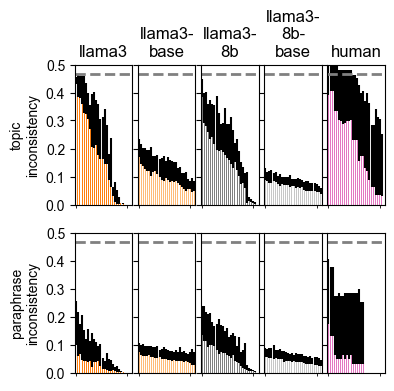

In [41]:
## English, US Rephrase inconsistency by model, topic

these_var_dfs = copy.deepcopy(filtered_var_dfs)
these_var_dfs.append(mturk_rephrase_var_df)
colors.append(ALL_MODEL_COLORS['human'])

columns = ['topic', 'original']

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(4, 4), sharey=True, sharex=True, squeeze=True)
fig.subplots_adjust(wspace=0.1) 


for (var, df), ax, color in zip(these_var_dfs, axes[1], colors):
    model = shorten_var_name(var, 'model').replace('-', '-\n')

    plot_consistency(var, df, columns, ax=ax, title='', color=color, plot_bound=True)
    # ax.tick_params(axis='x', labelsize=0)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('paraphrase\ninconsistency')

#####

these_var_dfs = copy.deepcopy(filtered_var_dfs)
these_var_dfs.append(mturk_topic_var_df)

columns = ['topic']

for (var, df), ax, color in zip(these_var_dfs, axes[0], colors):
    model = shorten_var_name(var, 'model').replace('-', '-\n')

    plot_consistency(var, df, columns, ax=ax, title=model, color=color, plot_bound=True)
    # ax.tick_params(axis='x', labelsize=0)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('topic\ninconsistency')

plt.savefig('notebooks/figures/model_topicwise_rephrase_topic_inconsisency_hist_base.pdf', bbox_inches='tight')
plt.show()

## un/controversial comparisons

controversial  uncontroversial
topic            0.127033         0.108620
paraphrase       0.049831         0.027529

controversial  uncontroversial
topic            0.217841         0.135920
paraphrase       0.082630         0.079189

controversial  uncontroversial
topic            0.193368         0.083577
paraphrase       0.043089         0.037945

controversial  uncontroversial
topic            0.231050         0.074554
paraphrase       0.094785         0.058240

controversial  uncontroversial
topic            0.205005         0.104283
paraphrase       0.074530         0.040198

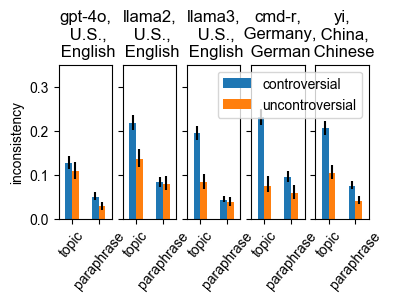

In [42]:
# models = ['meta-llama/Llama-2-70b-chat-hf', '01-ai/Yi-34B-Chat', 'stabilityai/japanese-stablelm-instruct-beta-70b']
models = ['gpt-4o',
          'meta-llama/Llama-2-7b-chat-hf',          
          'meta-llama/Llama-2-70b-chat-hf',
          'meta-llama/Meta-Llama-3-8B-Instruct',
          'meta-llama/Meta-Llama-3-70B-Instruct',
          'CohereForAI/c4ai-command-r-v01',
          '01-ai/Yi-34B-Chat',
          'stabilityai/japanese-stablelm-instruct-beta-70b']

countries = ['us', 'us', 'us', 'us', 'us', 'germany', 'china', 'japan']
languages = ['english', 'english', 'english', 'english', 'english', 'german', 'chinese', 'japanese']
variable = 'controversial'

num_figs = len(models)

fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(4, 2), sharey=True, squeeze=False)
# TODO: pay attention to multidimensionality of axes

for model, country, language, ax in zip(models, countries, languages, axes[0]):
    ### Get the data
    filenames = [f'controversial_{language}_{country}.jsonl',
                 f'uncontroversial_{language}_{country}.jsonl']
    
    var_dfs = []
    for file in filenames:
        all_dfs = get_data(file, {'model' : model,
                                 'version' : required_version,
                                  'allow_abstentions' : False,
                                  'task' : 'classification'})
        if model in all_dfs:
            var_dfs += [all_dfs[model][0]]

    ### Make the chart
    country = 'U.S.' if country == 'us' else country.title()
    title = f"{MODEL_NAMES_SHORT[model]},\n {country},\n {language.title()}"
    plot_consistency_by_variable(var_dfs, title, variable,
                                 before_after_filter=False, colors=SINGLE_COLORS, ax=ax)
    ax.set_ylim(*PRACTICAL_YLIM)

for i in range(len(axes[0]) - 1):
    ax = axes[0][i]
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

plt.savefig('notebooks/figures/models_controversial_uncontroversial.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [43]:
# TODO: do we want to have german uncontroversial for cmd-r? and english

## base model comparisons

In [44]:
paired_models = [
['meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf'],
['meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf'],    
['meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Meta-Llama-3-8B'],    
['meta-llama/Meta-Llama-3-70B-Instruct', 'meta-llama/Meta-Llama-3-70B'],
['01-ai/Yi-34B-Chat', '01-ai/Yi-34B'],
]

countries = ['us', 'us', 'us', 'us',  'china', 'japan']
languages = ['english', 'english', 'english', 'english', 'chinese', 'japanese']
variable = 'model_type'

num_figs = len(paired_models)

num_charts=len(paired_models)

num_colors = 4
all_colors = [PAIRED_COLORS[i:i + num_colors] for i in range(0, num_colors * num_charts, num_colors)]

all_titles = []
all_var_dfs = []

for models, country, language, in zip(paired_models, countries, languages):
    ### Get the data

    filename = f'controversial_{language}_{country}.jsonl'
    all_dfs = get_data(filename, {'model' : models,
                                'query_language' : language,
                                'version' : required_version,
                                'task' : 'classification',
                                'allow_abstentions' : False,
                                'randomize_option_order' : True})
    var_dfs = chain_var_dfs(all_dfs)
    country = 'U.S.' if country == 'us' else country.title()
    title = f"{MODEL_NAMES_SHORT[models[0]]}\n {language.title()},\n {country}"
    all_var_dfs.append(var_dfs)
    all_titles.append(title)

base      chat
topic       0.095492  0.305004
paraphrase  0.085970  0.237491

base      chat
topic       0.067878  0.217841
paraphrase  0.062752  0.082630

base      chat
topic       0.078643  0.184884
paraphrase  0.052561  0.081148

base      chat
topic       0.121992  0.193368
paraphrase  0.064136  0.043089

base      chat
topic       0.065514  0.205005
paraphrase  0.038762  0.074530

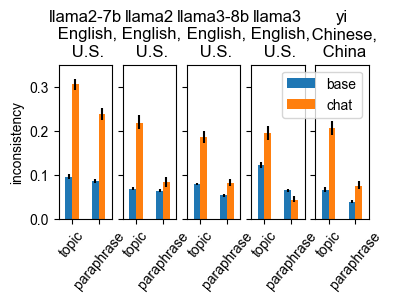

In [45]:
#### Consistency Measures

fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(4, 2), sharey=True, squeeze=False)
fig.subplots_adjust(wspace=0.2)

# TODO: pay attention to multidimensionality of axes

for title, var_dfs, ax in zip(all_titles, all_var_dfs, axes[0]):
    plot_consistency_by_variable(var_dfs, title, variable,
                                 before_after_filter=False, colors=SINGLE_COLORS, ax=ax)
    ax.set_ylim(*PRACTICAL_YLIM)

for i in range(len(axes[0]) - 1):
    ax = axes[0][i]
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

plt.savefig('notebooks/figures/models_base_aligned_consistency.pdf', bbox_inches='tight')
plt.show()

In [46]:
# Very important to run this!
# all_var_dfs = [ filter_var_dfs(var_dfs) for var_dfs in all_var_dfs]

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measu

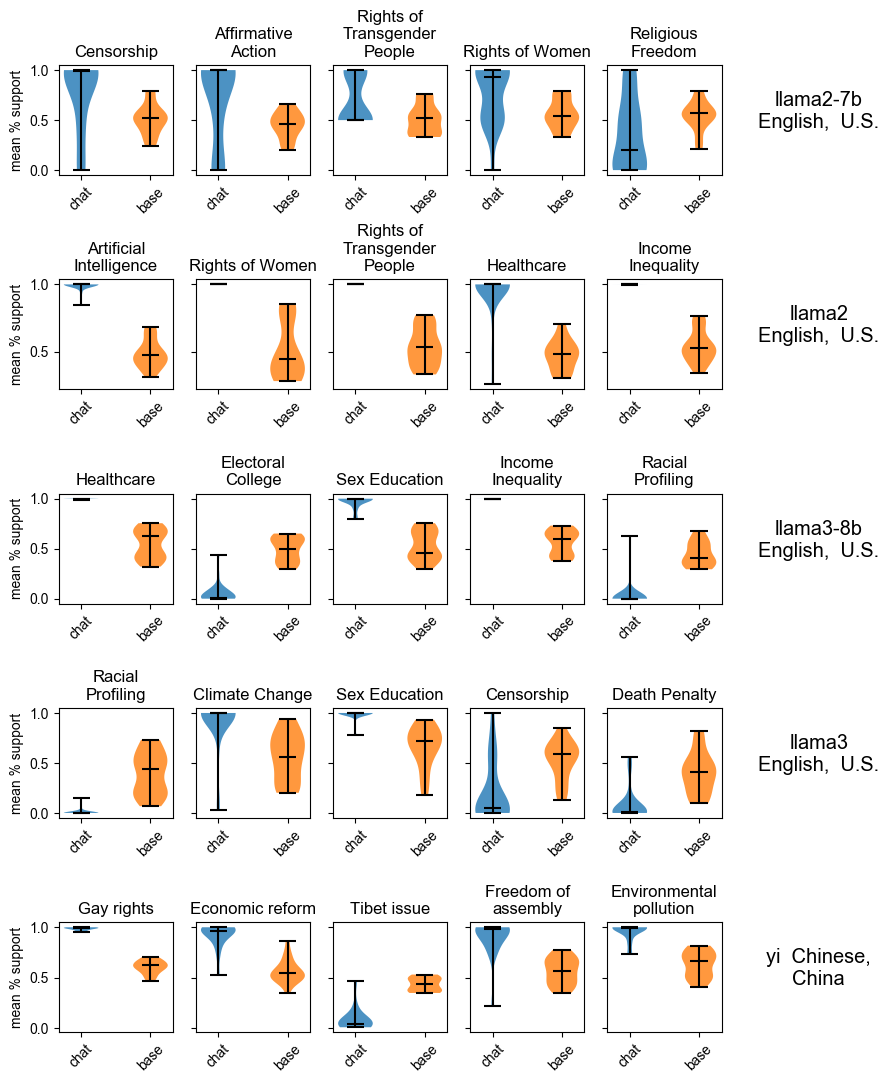

In [47]:
##### Topic Support

fig = plt.figure(figsize=(8, 2 * num_figs))
subfigs = fig.subfigures(nrows=num_figs, ncols=1, hspace=.5) #wspace=0.07)

for title, var_dfs, fig in zip(all_titles, all_var_dfs,  subfigs):

    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title,
                                    fig=fig, nplots=5, colors=SINGLE_COLORS)


plt.savefig('notebooks/figures/models_base_aligned_n_support.pdf', bbox_inches='tight')
plt.show()

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


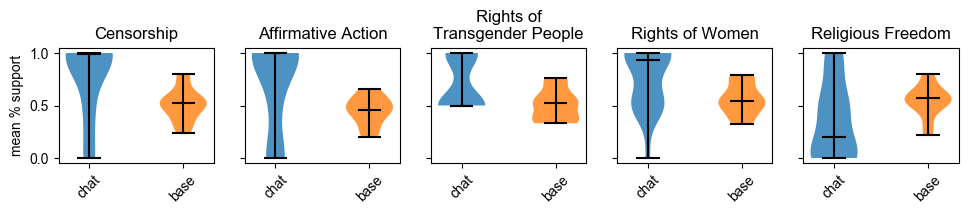

In [48]:
fig = plt.figure(figsize=(9, 1.5))

plot_topic_support_box_subplots(all_var_dfs[0], legend_variable=variable, title="", fig=fig,
                                nplots=5, ncols=5, colors=SINGLE_COLORS)

plt.savefig('notebooks/figures/models_base_aligned_support_english.pdf', bbox_inches='tight')
plt.show()

In [54]:
## Not plotting value change

# ###### Full figures per comparison

# for title, var_dfs in zip(all_titles, all_var_dfs):
#     plot_value_change_box_subplots(var_dfs, legend_variable=variable, colors=SINGLE_COLORS)
#     plt.show()
    
#     plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title, colors=SINGLE_COLORS)
#     plt.show()

#     ## TODO: save these figs?


## model comparisons

In [61]:

paired_models = [
['gpt-4o', 'meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Meta-Llama-3-70B-Instruct', 'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-70b-chat-hf', 'CohereForAI/c4ai-command-r-v01', '01-ai/Yi-34B-Chat'],
['gpt-4o', 'meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Meta-Llama-3-70B-Instruct',  'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-70b-chat-hf', 'CohereForAI/c4ai-command-r-v01', '01-ai/Yi-34B-Chat'],
['gpt-4o', 'meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Meta-Llama-3-70B-Instruct', 'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-70b-chat-hf', 'CohereForAI/c4ai-command-r-v01'],
['gpt-4o', 'meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Meta-Llama-3-70B-Instruct', 'CohereForAI/c4ai-command-r-v01', 'stabilityai/japanese-stablelm-instruct-beta-70b'],
]

countries = ['us', 'china', 'germany', 'japan']
languages = ['english', 'chinese', 'german', 'japanese']
variable = 'model'

num_figs = len(paired_models)

all_titles = []
all_var_dfs = []
all_colors = []

for models, country, language, in zip(paired_models, countries, languages):
    ### Get the data

    filename = f'controversial_{language}_{country}.jsonl'
    all_dfs = get_data(filename, {'model' : models,
                                'query_language' : language,
                                'version' : required_version,
                                'task' : 'classification',
                                'allow_abstentions' : False,
                                'randomize_option_order' : True})
    var_dfs = chain_var_dfs(all_dfs)
    country = "U.S." if country == 'us' else country.title()
    title = f"{language.title()}, {country}"
    all_var_dfs.append(var_dfs)
    all_colors.append([ALL_MODEL_COLORS[model] for model in models])
    all_titles.append(title)


cmd-r    gpt-4o    llama2  llama2-7b    llama3  llama3-8b  \
topic       0.179057  0.127033  0.217841   0.305004  0.193368   0.184884   
paraphrase  0.067964  0.049831  0.082630   0.237491  0.043089   0.081148   

                  yi  
topic       0.128749  
paraphrase  0.063842

cmd-r    gpt-4o    llama2  llama2-7b    llama3  llama3-8b  \
topic       0.22466  0.229207  0.246391   0.219436  0.173678   0.197360   
paraphrase  0.12732  0.069692  0.160147   0.199056  0.049657   0.061884   

                  yi  
topic       0.205005  
paraphrase  0.074530

cmd-r    gpt-4o    llama2  llama2-7b    llama3  llama3-8b
topic       0.231050  0.255876  0.318937   0.411331  0.281525   0.264112
paraphrase  0.094785  0.067983  0.057699   0.349567  0.058515   0.144326

cmd-r    gpt-4o    llama3  llama3-8b  stability
topic       0.202830  0.174613  0.202222   0.186793   0.108628
paraphrase  0.095897  0.028744  0.092364   0.039914   0.063881

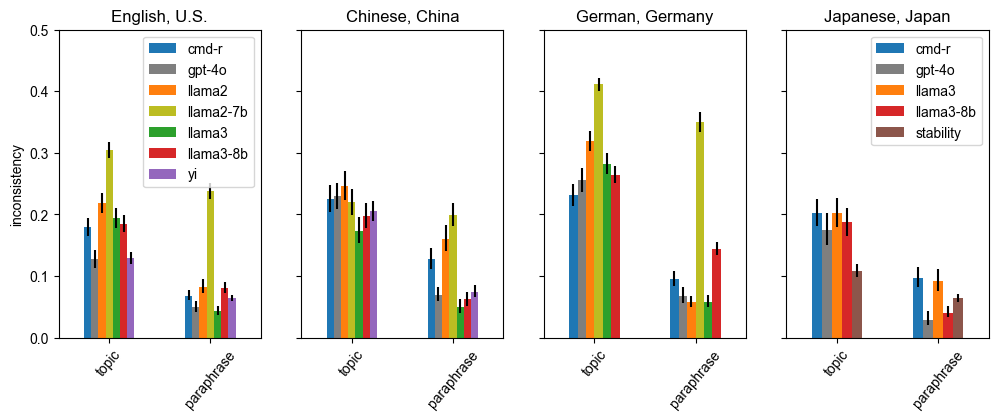

In [62]:
#### Consistency Measures

fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(12, 4), sharey=True, squeeze=False)
# TODO: pay attention to multidimensionality of axes

for title, var_dfs, colors, ax in zip(all_titles, all_var_dfs, all_colors, axes[0]):
    plot_consistency_by_variable(var_dfs, title, variable,
                                 before_after_filter=False, ax=ax, colors=colors)

for i in range(1, len(axes[0]) - 1):
    ax = axes[0][i]
    ax.get_legend().remove()

plt.savefig('notebooks/figures/models_comparison_consistency.pdf', bbox_inches='tight')
plt.show()

In [57]:
# Very important to run this after the consistency measure plots!
# NB: no longer filtering
# all_var_dfs = [ filter_var_dfs(var_dfs) for var_dfs in all_var_dfs]

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


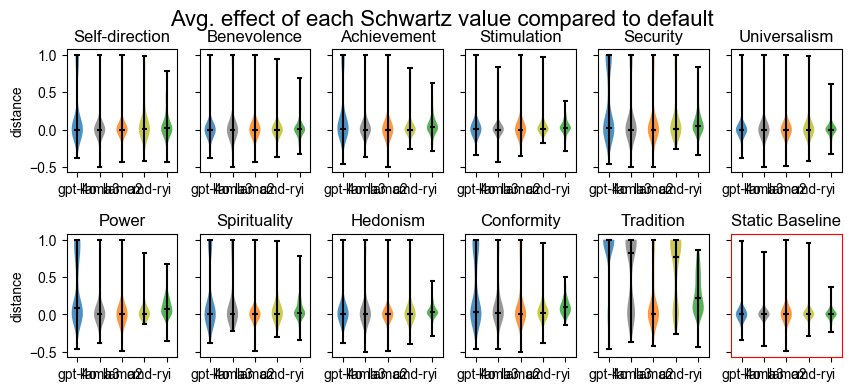

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


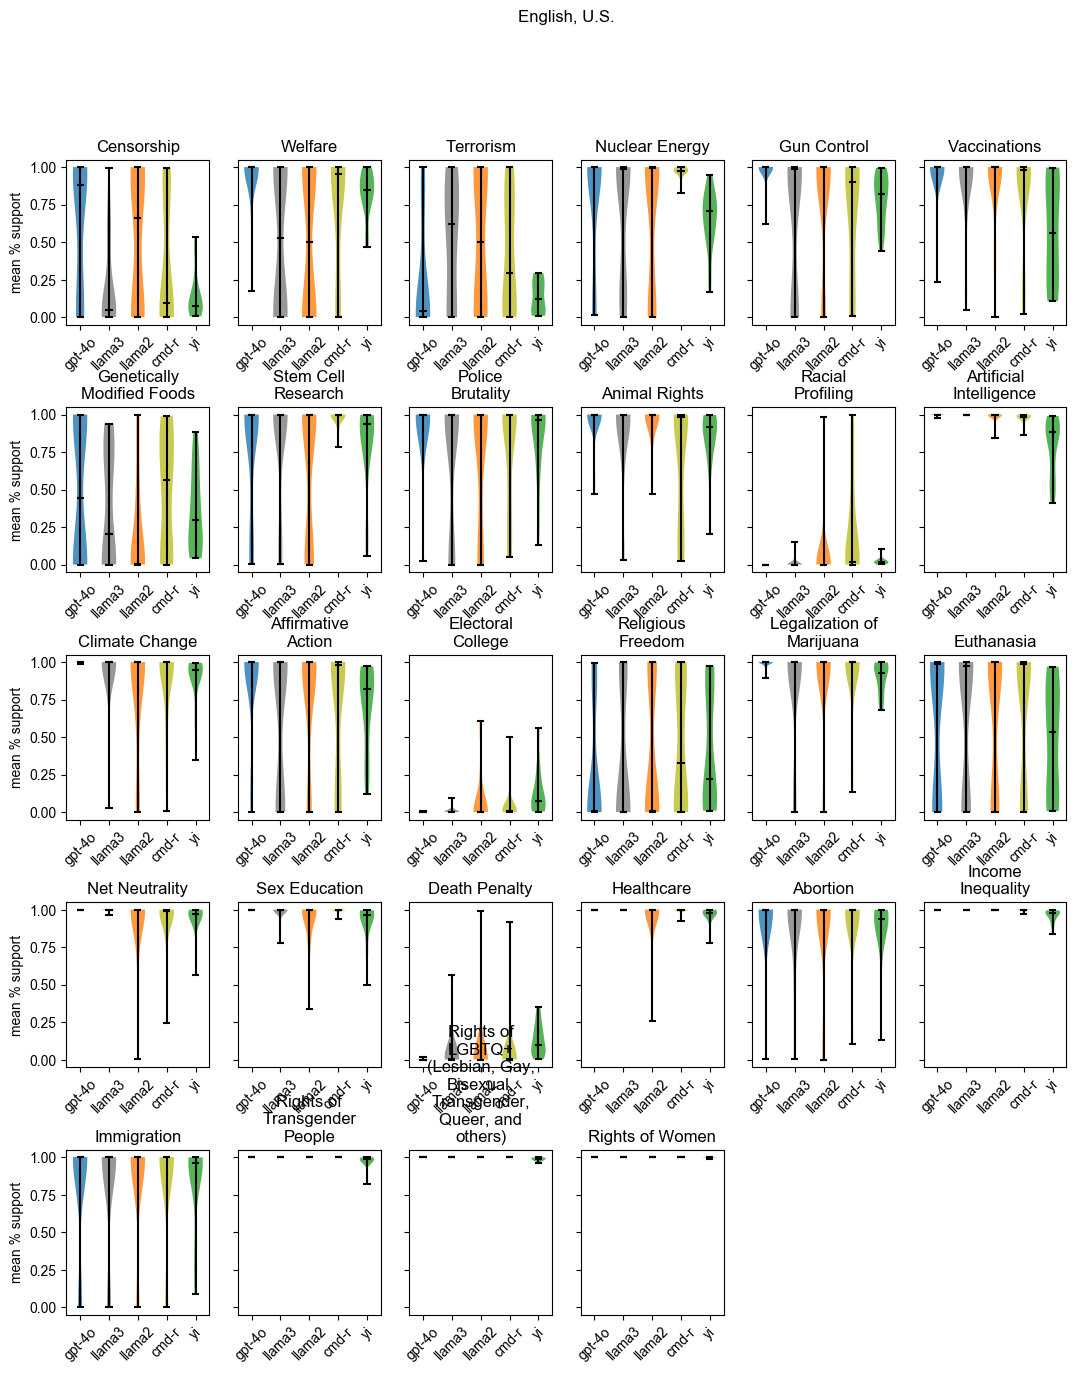

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


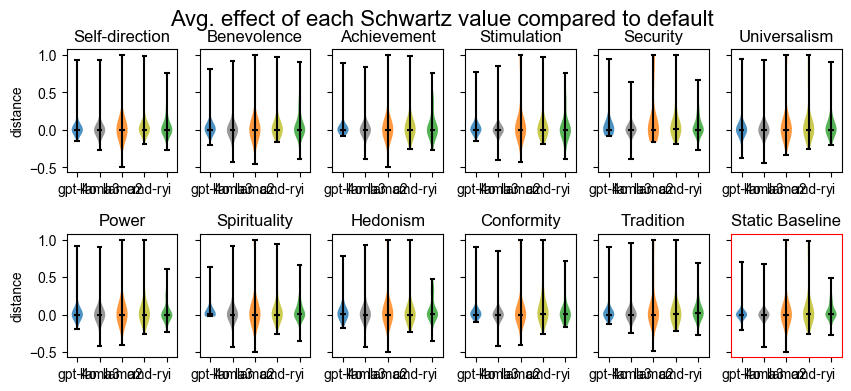

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


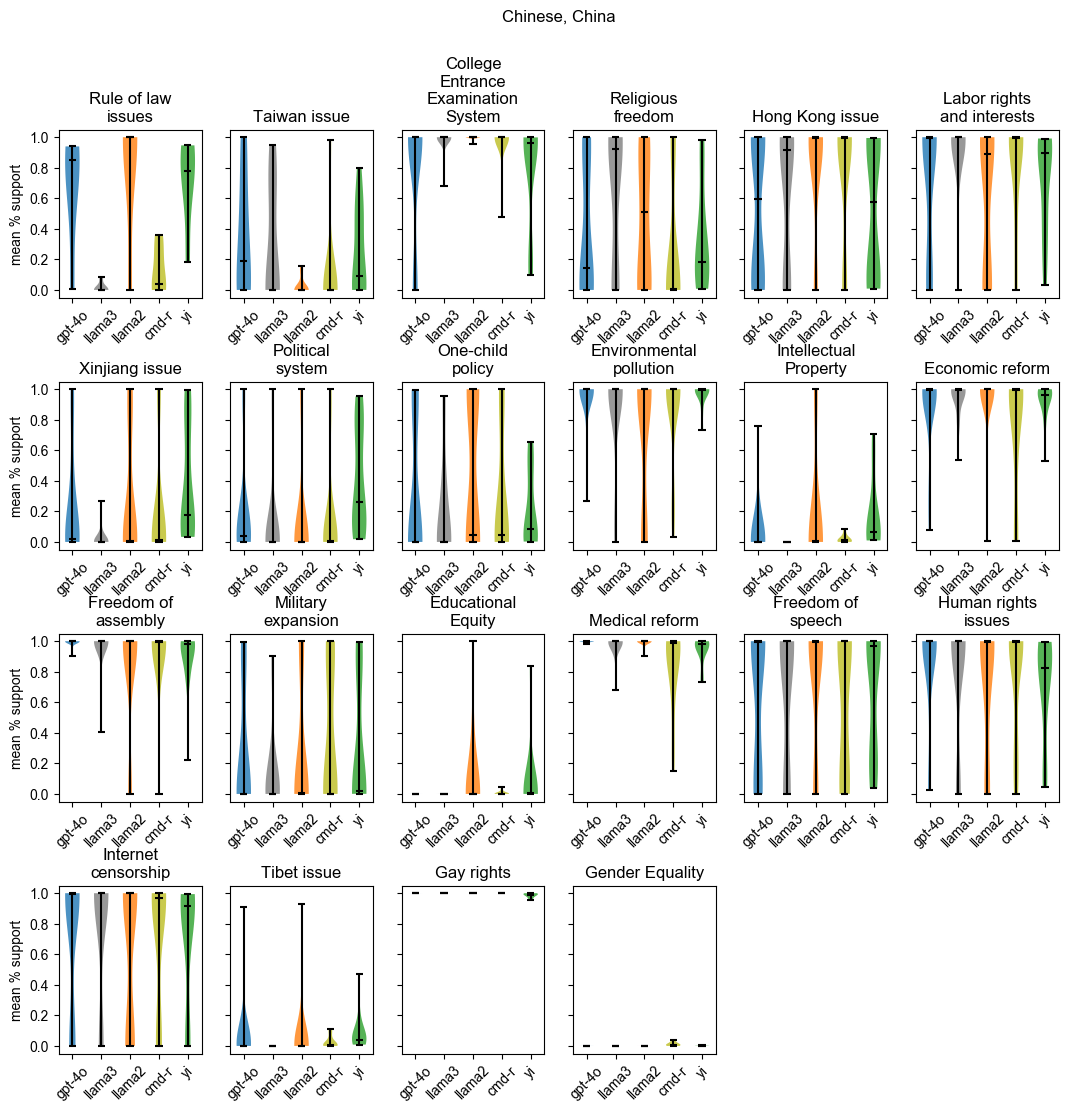

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


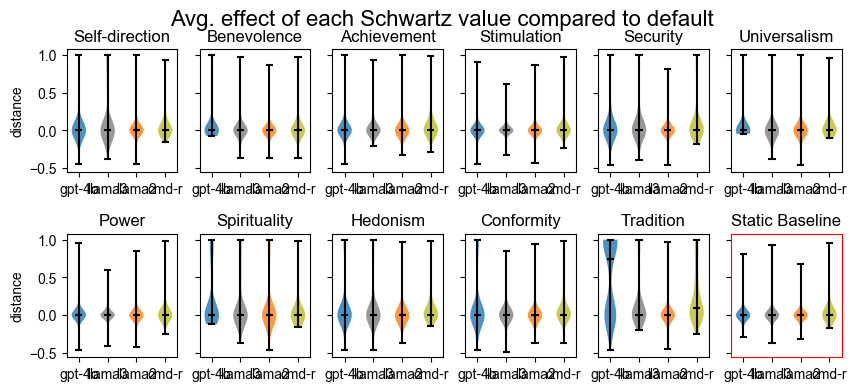

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


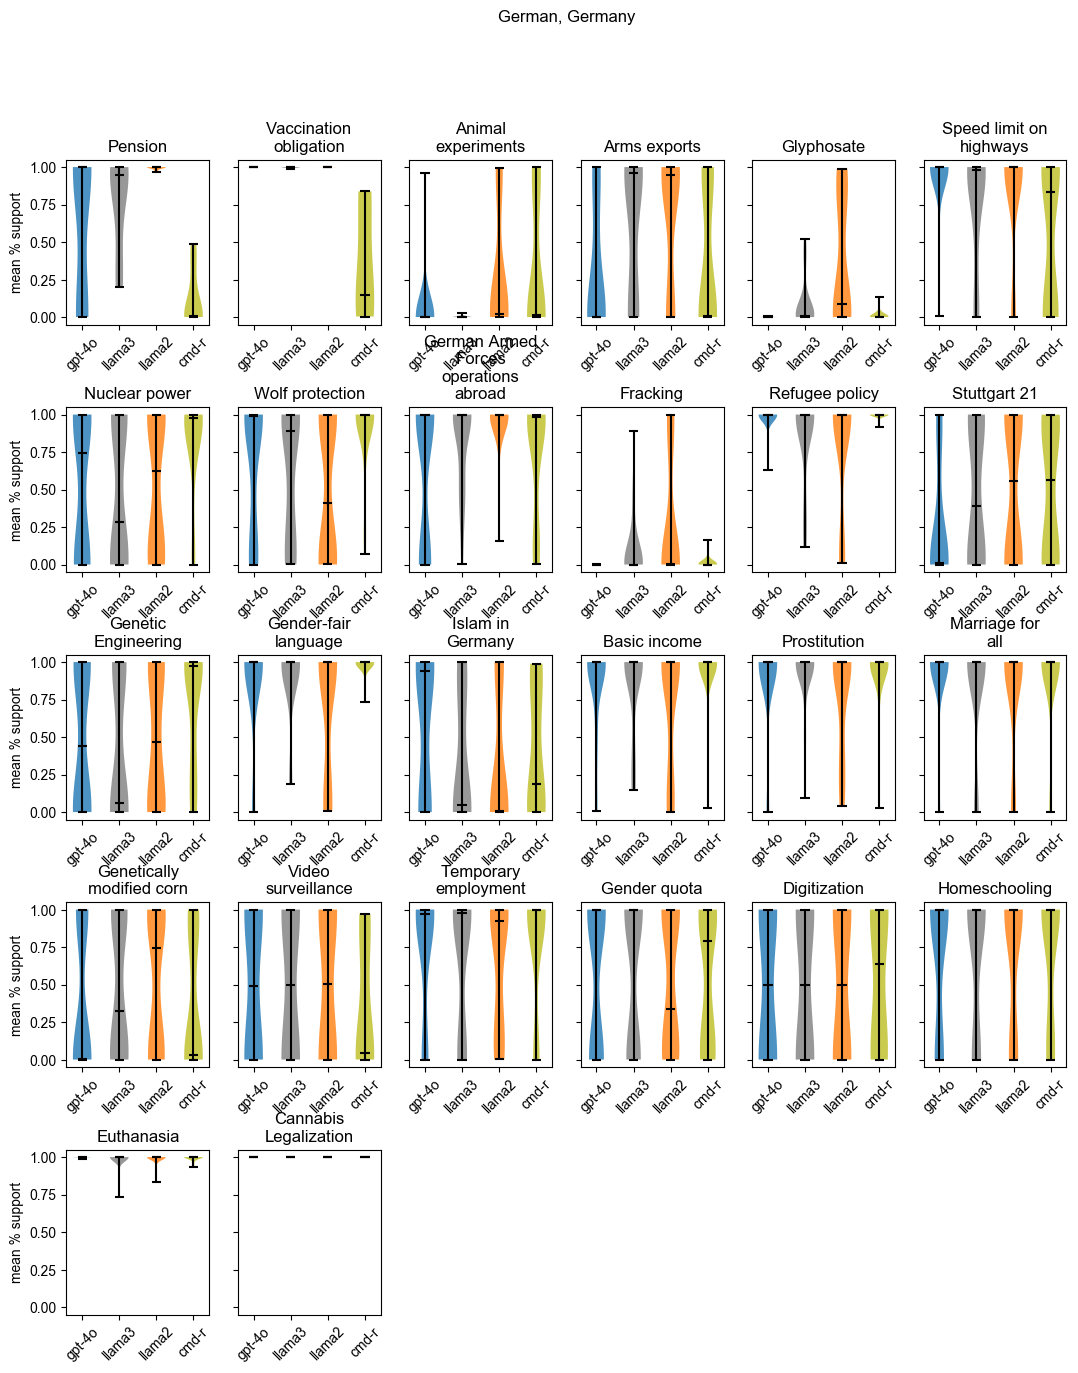

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


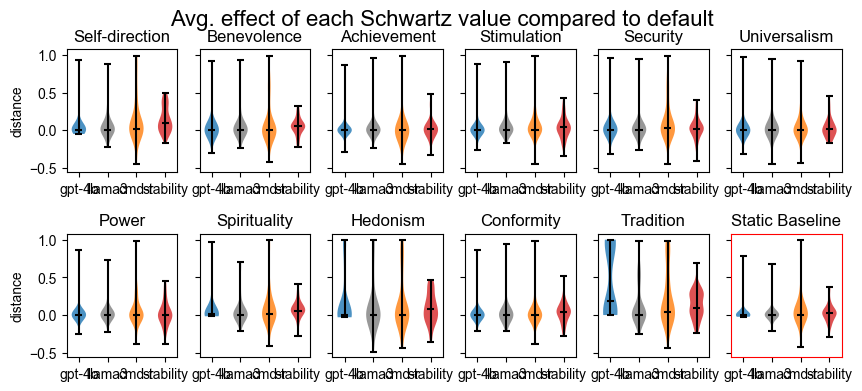

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


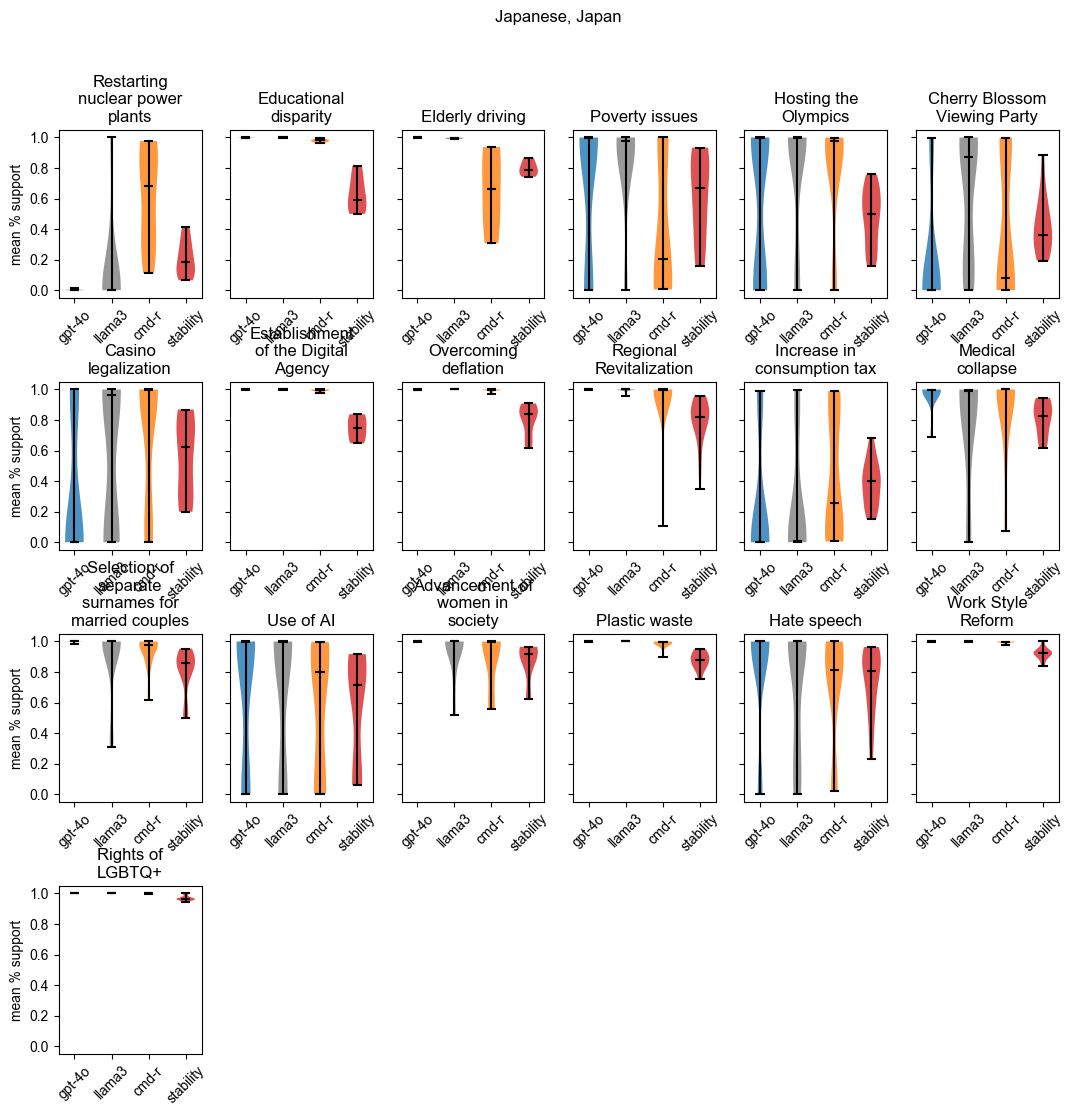

In [58]:
###### Full figures per comparison

for title, var_dfs, colors in zip(all_titles, all_var_dfs, all_colors):
    plot_value_change_box_subplots(var_dfs, legend_variable=variable, colors=colors)
    plt.show()
    
    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title, colors=colors)
    plt.show()

    ## TODO: save these figs?


/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


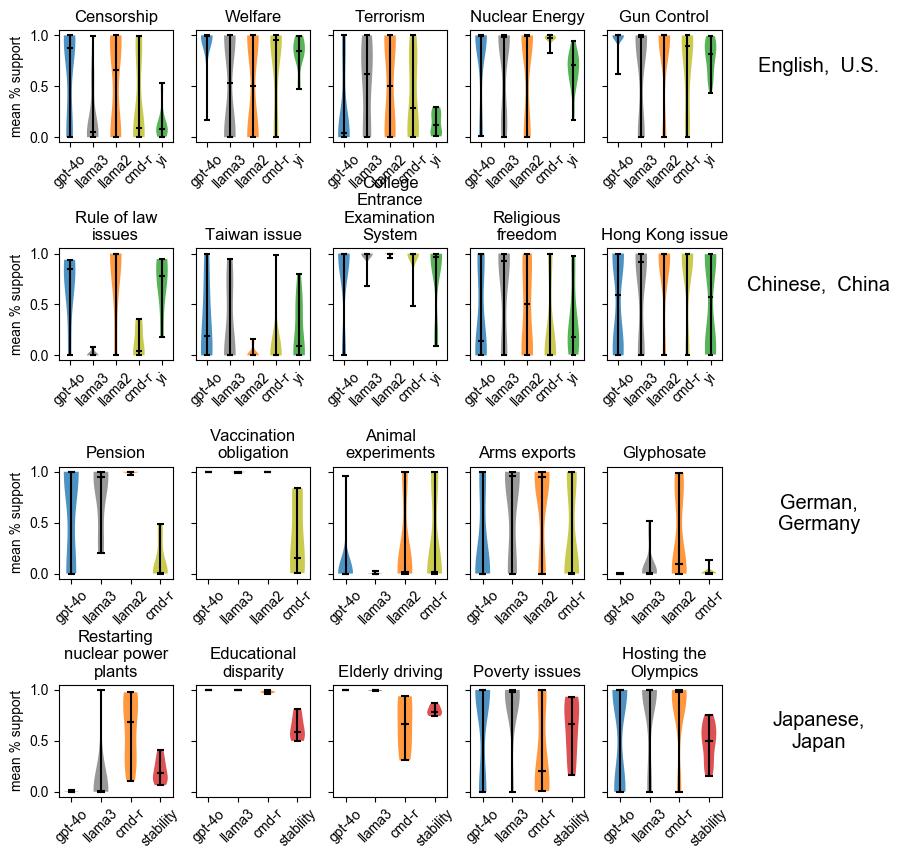

In [59]:
##### Topic Support

fig = plt.figure(figsize=(8, 2 * num_figs))
subfigs = fig.subfigures(nrows=num_figs, ncols=1, hspace=.5) #wspace=0.07)

for title, var_dfs, colors, fig in zip(all_titles, all_var_dfs, all_colors, subfigs):

    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title.replace(',', ',\n'),
                                     fig=fig, nplots=5, colors=colors)


plt.savefig('notebooks/figures/models_comparison_support.pdf', bbox_inches='tight')
plt.show()

/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])


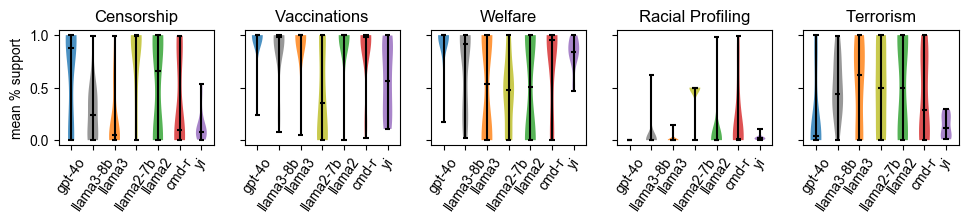

In [68]:
fig = plt.figure(figsize=(9, 1.5))

plot_topic_support_box_subplots(all_var_dfs[0], legend_variable=variable, title="", fig=fig,
                                nplots=5, ncols=5, colors=all_colors[0])

for ax in fig.get_axes():
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55)
# plt.savefig('notebooks/figures/models_comparison_support_english.pdf', bbox_inches='tight')
# plt.show()

## multilingual consistency

In [ ]:
# NB: Changed the version on controversial_english_japan/meta-llama_Lamma-270b-chat/classification-2024-04-06.jsonl
# just to test this flow

In [81]:
filename_str = 'controversial_{language}_{country}.jsonl'


models = ['gpt-4o',
          'meta-llama/Llama-2-7b-chat-hf',          
          'meta-llama/Llama-2-70b-chat-hf',
          'meta-llama/Meta-Llama-3-8B-Instruct',          
          'meta-llama/Meta-Llama-3-70B-Instruct',
          'CohereForAI/c4ai-command-r-v01',
          '01-ai/Yi-34B-Chat']

countries = ['us', 'us', 'us', 'us', 'us', 'us', 'china']
all_languages = [['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese', 'german', 'japanese'],
                 ['english', 'chinese']]

variable = 'language'

num_figs = len(models)

all_titles = []
all_var_dfs = []

for model, country, languages, in zip(models, countries, all_languages):
    ### Get the data
    filenames = [filename_str.format(language=lang, country=country) for lang in languages]

    var_dfs = []
    for file in filenames:
        all_dfs = get_data(file, {'model' : model,
                                 'version' : required_version,
                                  'allow_abstentions' : False,
                                  'task' : 'classification'})
        
        var_dfs += [all_dfs[model][0]]

    country = "U.S." if country == 'us' else country.title()
    title =  f"{MODEL_NAMES_SHORT[model]},\n{country}"
    all_var_dfs.append(var_dfs)
    all_titles.append(title)


Chinese   English    German  Japanese
topic       0.125397  0.127033  0.148933  0.161556
paraphrase  0.046370  0.049831  0.039188  0.060315

Chinese   English    German  Japanese
topic       0.228381  0.305004  0.402194  0.323056
paraphrase  0.180682  0.237491  0.347996  0.261513

Chinese   English    German  Japanese
topic       0.314998  0.217841  0.286147  0.304822
paraphrase  0.175603  0.082630  0.100525  0.170782

Chinese   English    German  Japanese
topic       0.207505  0.184884  0.233033  0.313561
paraphrase  0.105518  0.081148  0.155306  0.056259

Chinese   English    German  Japanese
topic       0.188687  0.193368  0.213093  0.241898
paraphrase  0.059842  0.043089  0.054406  0.069282

Chinese   English    German  Japanese
topic       0.205190  0.179057  0.192119  0.227283
paraphrase  0.090197  0.067964  0.081370  0.087893

Chinese   English
topic       0.205005  0.169977
paraphrase  0.074530  0.077568

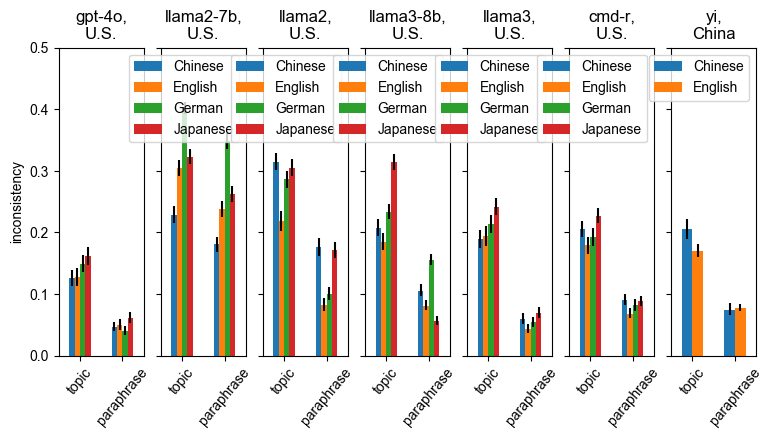

In [89]:
#### Consistency Measures

# colors = PAIRED_COLORS[:num_charts * 2]
# all_colors = [colors[:4], colors[:4], colors[:2] + colors[4:]]

fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(9, 4), sharey=True, squeeze=False)
# TODO: pay attention to multidimensionality of axes

for title, var_dfs, ax in zip(all_titles, all_var_dfs,  axes[0]):
    plot_consistency_by_variable(var_dfs, title, variable,
                                 before_after_filter=False, ax=ax)

# For whatever reason, I can't get rid of the legends
# for i in range(len(axes)):
#     if i == 5:
#         continue
#     axes[0][i].get_legend().remove()

plt.savefig('notebooks/figures/models_language_consistency.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Very important to run this after the consistency measure plots!
# all_var_dfs = [ filter_var_dfs(var_dfs) for var_dfs in all_var_dfs]

In [ ]:
###### Full figures per comparison

for title, var_dfs in zip(all_titles, all_var_dfs):
    plot_value_change_box_subplots(var_dfs, legend_variable=variable, colors=SINGLE_COLORS)
    plt.show()
    
    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title, colors=SINGLE_COLORS)
    plt.show()

    ## TODO: save these figs?


/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measures.py:214: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x if isinstance(x, list) or isinstance(x, np.ndarray) else [])
/Users/jared/workspace/valuebank/notebooks/measu

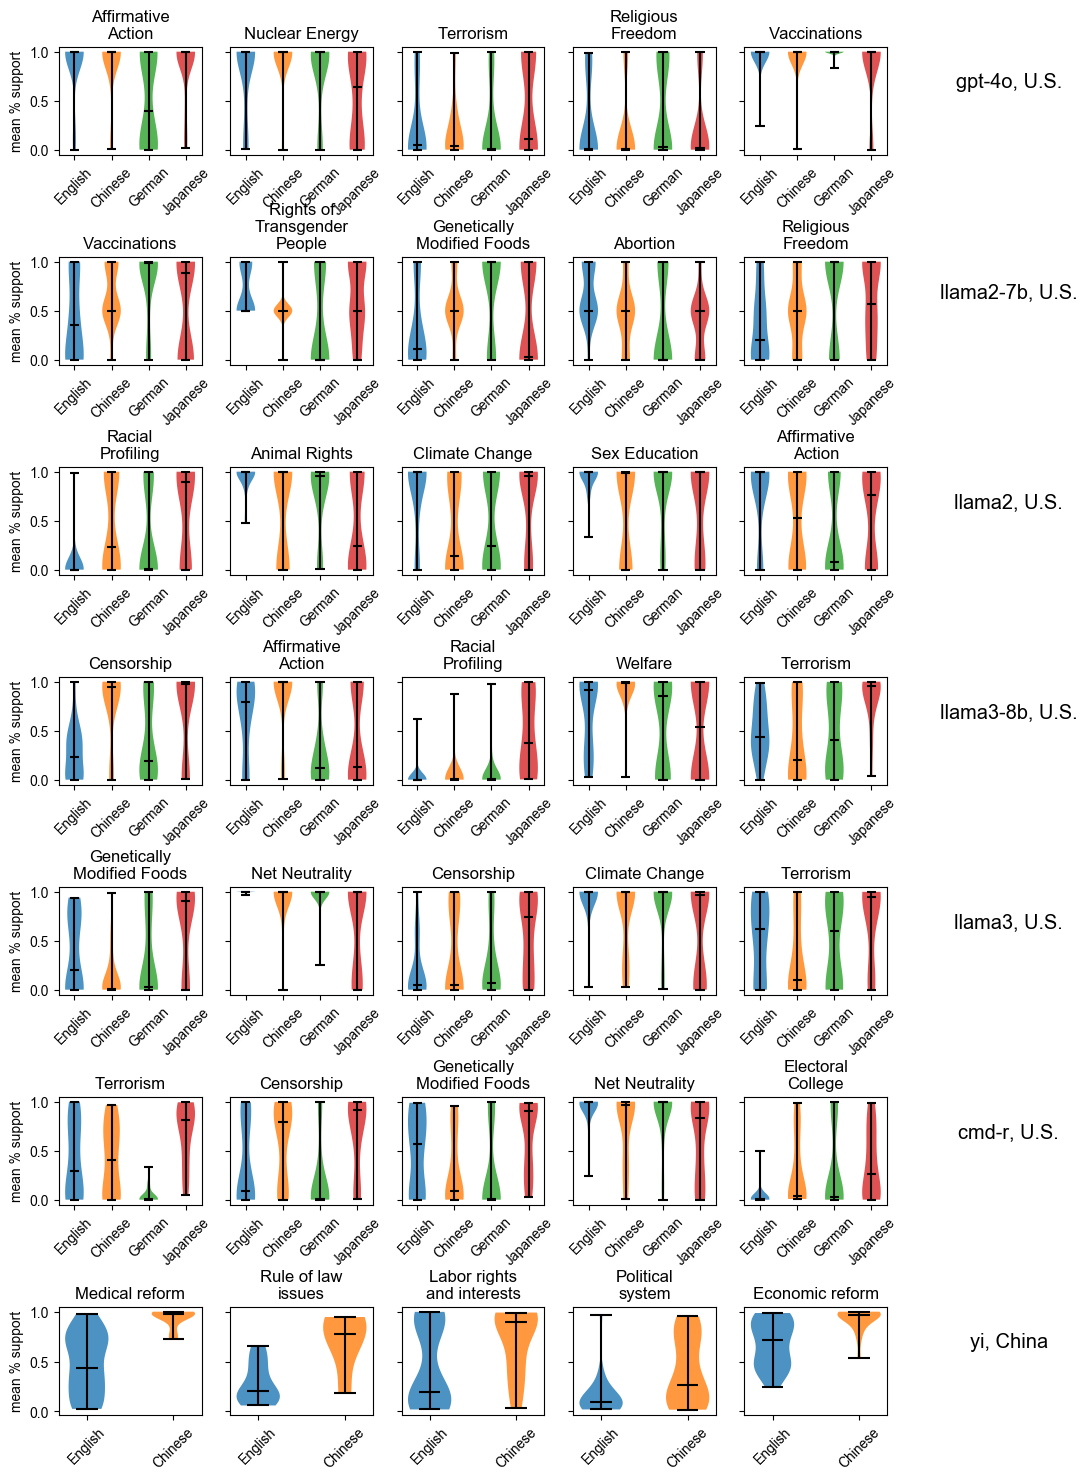

In [71]:
##### Topic Support

fig = plt.figure(figsize=(10, 2 * num_figs))
subfigs = fig.subfigures(nrows=num_figs, ncols=1, hspace=.5) #wspace=0.07)

for title, var_dfs, fig in zip(all_titles, all_var_dfs, subfigs):

    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title,
                                    colors=SINGLE_COLORS, fig=fig, nplots=5)


plt.savefig('notebooks/figures/models_language_support.pdf', bbox_inches='tight')
plt.show()

## Abstentions

In [ ]:
# TODO: this may be an invalid comparison... comparing 2 vs. 3 labels has inherent difference in d-d divergence

In [78]:
filename_str = 'controversial_{language}_{country}.jsonl'

models = ['gpt-4o',
          'meta-llama/Llama-2-7b-chat-hf',          
          'meta-llama/Llama-2-70b-chat-hf',
          'meta-llama/Meta-Llama-3-8B-Instruct',          
          'meta-llama/Meta-Llama-3-70B-Instruct',
          'CohereForAI/c4ai-command-r-v01',
          '01-ai/Yi-34B-Chat',
          'stabilityai/japanese-stablelm-instruct-beta-70b']

countries = ['us', 'us', 'us', 'us', 'us', 'germany', 'china', 'japan']
all_languages = ['english', 'english', 'english',  'english', 'english', 'german', 'chinese',  'japanese']

variable = 'allow_abstentions'

num_figs = len(models)

all_titles = []
all_var_dfs = []

for model, country, language, in zip(models, countries, all_languages):
    ### Get the data
    filename = filename_str.format(country=country, language=language)

    all_dfs = get_data(filename, {'model' : model,
                             'version' : required_version,
                              'task' : 'classification'})
    
    var_dfs = chain_var_dfs(all_dfs)

    country = "U.S." if country == 'us' else country.title()
    model_name = MODEL_NAMES_SHORT[model]
    if model_name == 'llama3-8b':
        model_name = 'llama3\n-8b' 
    if model_name == 'llama2-7b':
        model_name = 'llama2\n-7b'
    title =  f"{model_name},\n {country}"
    all_var_dfs.append(var_dfs)
    all_titles.append(title)


abstain  no abstain
topic       0.136858    0.127033
paraphrase  0.045750    0.049831

abstain  no abstain
topic       0.324561    0.305004
paraphrase  0.223982    0.237491

abstain  no abstain
topic       0.220057    0.217841
paraphrase  0.062891    0.082630

abstain  no abstain
topic       0.205768    0.184884
paraphrase  0.093835    0.081148

abstain  no abstain
topic       0.199227    0.193368
paraphrase  0.056169    0.043089

abstain  no abstain
topic       0.249445    0.231050
paraphrase  0.121208    0.094785

abstain  no abstain
topic       0.255076    0.205005
paraphrase  0.166580    0.074530

abstain  no abstain
topic       0.151308    0.108628
paraphrase  0.093089    0.063881

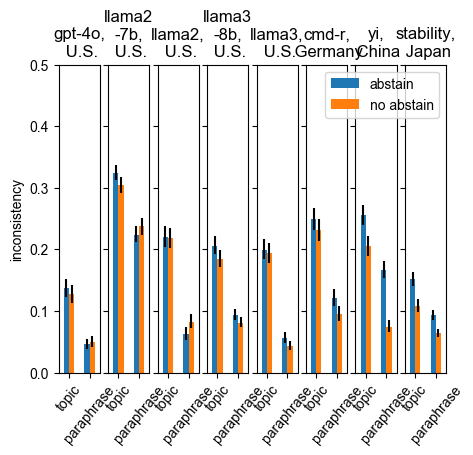

In [79]:
#### Consistency Measures

fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(5, 4), sharey=True, squeeze=False)
# TODO: pay attention to multidimensionality of axes

for title, var_dfs, ax in zip(all_titles, all_var_dfs, axes[0]):
    plot_consistency_by_variable(var_dfs, title, variable, as_fraction_of_max=False,
                                 before_after_filter=False, colors=SINGLE_COLORS, ax=ax)

for i in range(len(axes[0]) - 1):
    ax = axes[0][i]
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

plt.savefig('notebooks/figures/models_abstention_consistency.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#### Consistency Measures

fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(5, 4), sharey=True, squeeze=False)
# TODO: pay attention to multidimensionality of axes

for title, var_dfs, ax in zip(all_titles, all_var_dfs, axes[0]):
    plot_consistency_by_variable(var_dfs, title, variable, as_fraction_of_max=True,
                                 before_after_filter=False, colors=SINGLE_COLORS, ax=ax)

for i in range(len(axes[0]) - 1):
    ax = axes[0][i]
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('% of max inconsistency (D-D div.)')

plt.savefig('notebooks/figures/models_abstention_consistency_of_max.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Very important to run this after the consistency measure plots!
#all_var_dfs = [ filter_var_dfs(var_dfs) for var_dfs in all_var_dfs]

In [ ]:
###### Full figures per comparison

for title, var_dfs in zip(all_titles, all_var_dfs):
    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title, colors=SINGLE_COLORS)
    plt.show()

    ## TODO: save these figs?


In [ ]:
##### Topic Support

fig = plt.figure(figsize=(8, 2 * num_figs))
subfigs = fig.subfigures(nrows=num_figs, ncols=1, hspace=.5) #wspace=0.07)

for title, var_dfs, fig in zip(all_titles, all_var_dfs, subfigs):

    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title,
                                    colors=SINGLE_COLORS, fig=fig, nplots=5)


plt.savefig('notebooks/figures/models_abstention_support.pdf', bbox_inches='tight')
plt.show()

## use-case (task) consistency

In [ ]:
filename_str = 'controversial_{language}_{country}.jsonl'

models = ['gpt-4o',
          'meta-llama/Llama-2-70b-chat-hf',
          'meta-llama/Meta-Llama-3-70B-Instruct',
          'CohereForAI/c4ai-command-r-v01',
          '01-ai/Yi-34B-Chat',
          'stabilityai/japanese-stablelm-instruct-beta-70b']

countries = ['us', 'us', 'us', 'germany', 'china', 'japan']
languages = ['english', 'english', 'english', 'german', 'chinese', 'japanese']

variable = 'task'

num_figs = len(models)

all_titles = []
all_var_dfs = []

for model, country, language, in zip(models, countries, languages):
    ### Get the data
    filename = f'controversial_{language}_{country}.jsonl'

    var_dfs = []
    all_dfs = get_data(filename, {'model' : model,
                                  'version' : required_version,
                                  'allow_abstentions' : False})
        
    var_dfs += all_dfs[model]

    var_dfs = list(filter(use_case_filter, var_dfs))

    title =  f"{MODEL_NAMES_SHORT[model]}"
    all_var_dfs.append(var_dfs)
    all_titles.append(title)


In [ ]:
#### Consistency Measures

# colors = PAIRED_COLORS[:num_charts * 2]
# all_colors = [colors[:4], colors[:4], colors[:2] + colors[4:]]

fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(4, 2), sharey=True, squeeze=False)
# TODO: pay attention to multidimensionality of axes

for title, var_dfs, ax in zip(all_titles, all_var_dfs, axes[0]):
    # not_pca_var_dfs = list(filter(not_pca, var_dfs))
    plot_consistency_by_variable(var_dfs, title, variable,
                                 before_after_filter=False, colors=SINGLE_COLORS, ax=ax)
    ax.set_ylim(*PRACTICAL_YLIM)


for i in [0, 1, 3, 4, 5]:
    ax = axes[0][i]
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

plt.savefig('notebooks/figures/models_generation_consistency.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# #### Consistency Measures

# colors = PAIRED_COLORS[:num_charts * 2]
# all_colors = [colors[:4], colors[:4], colors[:2] + colors[4:]]

# fig, axes = plt.subplots(ncols=num_figs, nrows=1, figsize=(12, 4), sharey=True, squeeze=False)
# # TODO: pay attention to multidimensionality of axes

# for title, var_dfs, colors, ax in zip(all_titles, all_var_dfs, all_colors, axes[0]):
#     pca_var_dfs = list(filter(is_pca, var_dfs))
#     plot_consistency_by_variable(pca_var_dfs, title, variable,
#                                  before_after_filter=True, colors=PAIRED_COLORS, ax=ax)

# for i in range(len(axes[0]) - 1):
#     ax = axes[0][i]
#     handles, labels = ax.get_legend_handles_labels()
#     ax.get_legend().remove()

# plt.savefig('notebooks/figures/models_generation_pca_consistency.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
###### Full figures per comparison

for title, var_dfs in zip(all_titles, all_var_dfs):
    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title, colors=SINGLE_COLORS)
    plt.show()

    ## TODO: save these figs?


In [ ]:
##### Topic Support

fig = plt.figure(figsize=(8, 2 * num_figs))
subfigs = fig.subfigures(nrows=num_figs, ncols=1, hspace=.5) #wspace=0.07)

for title, var_dfs, fig in zip(all_titles, all_var_dfs, subfigs):
    plot_topic_support_box_subplots(var_dfs, legend_variable=variable, title=title,
                                    colors=SINGLE_COLORS, fig=fig, nplots=5)


plt.savefig('notebooks/figures/models_generation_support.pdf', bbox_inches='tight')
plt.show()

### Check annotator consistency

In [ ]:
models = [
'gpt-4o',
'meta-llama/Llama-2-70b-chat-hf',
'meta-llama/Meta-Llama-3-70B-Instruct',    
'CohereForAI/c4ai-command-r-v01',
'01-ai/Yi-34B-Chat',
'stabilityai/japanese-stablelm-instruct-beta-70b'
]

is_annotated = lambda var_df: 'annotator' in var_df[0] and var_df[0]['annotator']

def filter_consistent_answers(dfs):
    if len(dfs) == 0:
        return []
    # Find consistent answers for each id
    delete_ids = []

    for i in range(dfs[0][1].shape[0]):
        answer_set = set()
        for df in dfs:
            answer_set.add(df[1].iloc[i]["answer"])
        if len(answer_set) > 1:
            delete_ids.append(i)
        
    # Keep ids with consistent answers
    for i in range(len(dfs)):
        indices_to_drop = dfs[i][1].index[delete_ids]

        dfs[i] = (dfs[i][0], dfs[i][1].drop(indices_to_drop))
    
    # Filter each dataframe based on consistent ids
    return dfs

all_var_dfs = []
all_titles = []

for model, country, language, in zip(models, COUNTRIES, LANGUAGES):
    ### Get the data
    filename = f'controversial_{language}_{country}.jsonl'

    var_dfs = []
    all_dfs = get_data(filename, {'model' : model,
                                  'version' : required_version})
        
    var_dfs += all_dfs[model]
    

    var_dfs = list(filter(is_annotated, var_dfs))

    
    true_positive_dataframes = [(meta,df) for meta, df in var_dfs if 'annotator_abstentions' in meta and meta['annotator_abstentions'] and meta['stance'] == True]
    true_negative_dataframes = [(meta,df) for meta, df in var_dfs if 'annotator_abstentions' in meta and meta['annotator_abstentions'] and meta['stance'] == False]
    false_positive_dataframes = [(meta,df) for meta, df in var_dfs if 'annotator_abstentions' in meta and not meta['annotator_abstentions'] and meta['stance'] == True]
    false_negative_dataframes = [(meta,df) for meta, df in var_dfs if 'annotator_abstentions' in meta and not meta['annotator_abstentions'] and meta['stance'] == False]

    filtered_true_positive_dfs = filter_consistent_answers(true_positive_dataframes)
    filtered_true_negative_dfs = filter_consistent_answers(true_negative_dataframes)
    filtered_false_positive_dfs = filter_consistent_answers(false_positive_dataframes)
    filtered_false_negative_dfs = filter_consistent_answers(false_negative_dataframes)
    
    
    var_dfs = []
    var_dfs += filtered_true_positive_dfs
    var_dfs += filtered_true_negative_dfs
    var_dfs += filtered_false_positive_dfs
    var_dfs += filtered_false_negative_dfs

    var_dfs = list(filter(only_abstain_filter, var_dfs))
    title =  f"{MODEL_NAMES_SHORT[model]}"
    all_var_dfs.append(var_dfs)
    all_titles.append(title)

#### Consistency Measures

fig, axes = plt.subplots(ncols=len(all_var_dfs), nrows=1, figsize=(11, 4), sharey=True, squeeze=False)

for title, var_dfs, ax in zip(all_titles, all_var_dfs, axes[0]):
    plot_consistency_by_variable(var_dfs, title, 'annotator',
                                 before_after_filter=False, colors=SINGLE_COLORS, ax=ax)

plt.savefig('notebooks/figures/models_annotator_agreement_broken_down.pdf', bbox_inches='tight')
plt.show()